In [2]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight

sys.path.append('../bitome-kb/')
from pathlib import Path
from bitome.core import Bitome
from math import log,exp,inf
bitome = Bitome.init_from_file('../bitome-kb/bitome.pkl')
from feature_functions import *

In [3]:
from Bio.SeqFeature import FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq

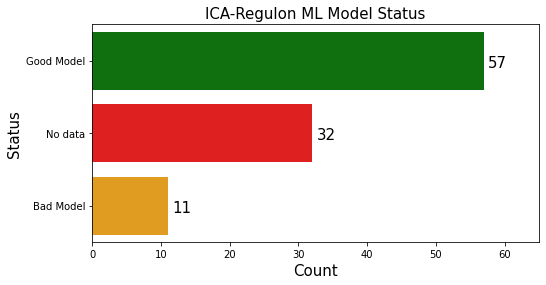

In [25]:
data = {"status": ["Good Model", "No data", "Bad Model"],"count": [57,32,11]}
df = pd.DataFrame(data, columns=['status', 'count'])
colors = {"Good Model":'green',"No data":'red',"Bad Model":'orange'}
clrs= [ colors[x] for x in data['status']]
plt.figure(figsize=(8,4))

plots = sns.barplot(x="count", y="status", data=df, palette= clrs)
  
# Iterrating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(int(bar.get_width()), 
                   ( bar.get_width()+2,bar.get_y() + bar.get_height() / 1.5 ), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Count", fontsize=15)
plt.ylabel("Status", fontsize=15)
plt.title("ICA-Regulon ML Model Status",fontsize=15)
plt.xlim([0,65])
plt.savefig("../../thesis_plots/model_status.svg",dpi=150)
plt.show()

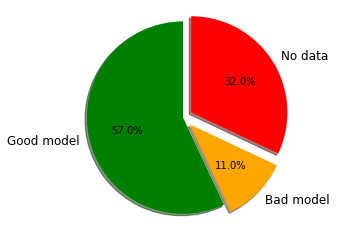

In [25]:
labels = ['Good model', 'Bad model', 'No data']
sizes = [57, 11, 32]
explode = (0, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
wedges, texts, autotexts = ax1.pie(sizes, labels=labels,explode = explode,
                                   autopct='%1.1f%%',colors=['green','orange','red'],
            shadow=True, startangle=90, textprops={'color':"k"})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
texts[0].set_fontsize(12)
texts[1].set_fontsize(12)
texts[2].set_fontsize(12)
plt.savefig("../../thesis_plots/model_status_pie.svg",dpi=150)
plt.show()

In [16]:
import ast
im_info = pd.read_csv('data/precise2_im_info_new.csv')
IM_genes = {}
for i in range(len(im_info['im_name'])):
    IM_genes[im_info['im_name'][i]] = ast.literal_eval( im_info['genes'][i] )
IM_genes.keys()

dict_keys(['CysB-1', 'HprR+CusR', 'PhoB-1', 'Fnr-1', 'TdcAR', 'Fimbriae', 'PurR-2', 'Fnr+NarL', 'GalRS', 'BtsR', 'PyrR', 'PlaR', 'RpoN+FhlA', 'RhaS', 'NanR', 'FadR', 'NrdR', 'GlcC', 'BaeR+CpxR', 'NikR', 'Isoleucine', 'RpoN+PspF', 'OxyR', 'TrpR', 'CsqR', 'LldR', 'Thiamine-1', 'PuuR', 'YcjW', 'PdhR+OmpR', 'NsrR', 'GntR', 'Fnr+NarLP', 'RcsAB', 'MalT', 'TyrR', 'Molybdopterin', 'Fnr-2', 'AtoC', 'Leucine', 'SoxS', 'Translation', 'RcnR', 'Lrp', 'Nac', 'KdpE', 'PhoB-2', 'RbsR', 'CysB-2', 'FlhDC-1', 'GatR', 'ArgR', 'GadX', 'RpoN+NtrC-1', 'XylR', 'ArcA', 'BirA', 'EvgA', 'BluR', 'LsrR', 'Zur', 'RpoE', 'Fur-1', 'PurR-1', 'ArgP', 'AllR', 'FucR', 'Fur-2', 'Mlc', 'CecR', 'Fnr+IHF+gcvB', 'YgbI', 'LexA', 'Cra', 'GlpR', 'RpoN+NtrC-2', 'PaaX', 'Oligopeptide', 'CdaR', 'RpoN+PrpR+Cra', 'FliA', 'CpxR', 'Histidine', 'RpoH', 'GadE+FliZ', 'GcvA', 'YdeO+H-NS', 'NagC', 'GutM+SrlR', 'MetJ', 'RpoS', 'CysB-3', 'FlhDC-2', 'RutR', 'PhoP', 'RyhB', 'BasR', 'NarL', 'RpoS+ArgR+RpoN', 'Crp-related-2'])

In [5]:
features = pd.read_csv('features_avg.csv')
S = pd.read_csv('data/S.csv')
features.columns

Index(['ID', 'strand', 'TU_length', 'leading', 'lagging', 'terminus',
       'Sigma70_Prib_Start', 'Sigma70_Prib_score', 'Sigma70_Prib_hmd',
       'Sigma70_Prib_Tm',
       ...
       'EP_TSS_1', 'EP_TSS_2', 'EP_TSS_3', 'EP_TSS_4', 'EP_TSS_5', 'EP_TSS_6',
       'EP_TSS_7', 'EP_TSS_8', 'EP_TSS_9', 'EP_TSS_10'],
      dtype='object', length=2192)

In [6]:
X = features.iloc[:,1:].values
X = StandardScaler().fit_transform(X)
ID = list(features['ID'])

In [7]:
target_labels={}
for r in IM_genes.keys():
    target_labels[r] = []
    for i in range( len(ID) ):
        if ID[i] in IM_genes[r]:
            target_labels[r].append( 1 )
        else:
            target_labels[r].append( 0 )          

In [8]:
pwm_db = rpwm('data/motif_pwm_db.txt')
pwm_im = rlogodds('data/motif_logodds.txt')
IM_motif_to_use = list( set(pwm_im.keys())&set(IM_genes.keys()) )

tf_list =['AraC', 'ArcA', 'ArgP', 'ArgR', 'BaeR', 'BasR', 'CysB', 'CpxR', 
          'Cra', 'CRP', 'Mlc', 'MqsA', 'EvgA', 'ExuR', 'FadR', 'IclR', 'IscR', 
          'IHF', 'FhlA', 'FlhDC', 'FNR', 'Fur', 'GadE', 'GadW', 'GadX', 'GalR', 'GalS', 
          'GcvA', 'GlpR', 'GlrR', 'GntR', 'TyrR', 'LexA', 'LeuO', 'Lrp', 'MalT', 'MetJ', 'Nac', 
          'NagC', 'NanR', 'NarL', 'NarP', 'NrdR', 'NsrR', 'NtrC', 'OmpR', 'OxyR', 'PdhR', 'PhoB', 'PhoP',
          'PurR', 'PuuR', 'RcsAB', 'RhaS', 'RutR', 'SoxS', 'TrpR', 'XylR', 'YdeO']
regulon_genes={}
for TF in bitome.transcription_factors:
    if TF.name in tf_list:
        regulon_genes[TF.name] = []   
        for r in TF.regulons:
                for p in list(r.regulated_promoters.values())[0]:
                    if p.transcription_unit != None and len(p.transcription_unit.genes)>0:
                        for g in p.transcription_unit.genes:
                            regulon_genes[TF.name].append( g.locus_tag)
# cobvert gene name and b number.
b_g = {}
for g in bitome.genes:
    b_g[ g.locus_tag ] = g.name
#regulon_labels
regulon_labels = {}
for r in regulon_genes.keys():
    regulon_labels[r] = []
    for i in range( len(ID) ):
        if ID[i] in regulon_genes[r]:
            regulon_labels[r].append( 1 )
        else:
            regulon_labels[r].append( 0 )

In [9]:
motif_list = list(regulon_genes.keys())
for im_motif in IM_motif_to_use:
    motif_list.append( im_motif + ' im')

## LDA on shape features

In [10]:
w_shape = {}
X_shape = {}
Xld_shape = {}
for r in motif_list:
    f_name = r
    if f_name == 'FNR':
        f_name = 'Fnr'
    if f_name == 'CRP':
        f_name = 'Crp'
        
    shape_f_list = [f_name +' HelT_avg', f_name +' HelT_range', f_name + ' MGW_avg',f_name + ' MGW_range',
       f_name +' ProT_avg', f_name +' ProT_range',f_name +' Roll_avg',f_name +' Roll_range',
       f_name +' HelT_max',f_name +' HelT_min',f_name +' MGW_max',f_name +' MGW_min',
       f_name +' ProT_max',f_name +' ProT_min',f_name +' Roll_max',f_name +' Roll_min']
    X_shape[f_name] = features[ shape_f_list ].iloc[:,:].values
    if r in regulon_genes.keys():
        w_shape[f_name] = ld( X_shape[f_name], regulon_labels[r] )
    else:
        im_name = r[:-3]
        w_shape[f_name] = ld( X_shape[f_name], target_labels[im_name] )
        
    Xld_temp = []
    for v in X_shape[f_name]:
        Xld_temp.append(  np.matmul( w_shape[f_name] , v) )
    Xld_shape[f_name] = Xld_temp

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argumen

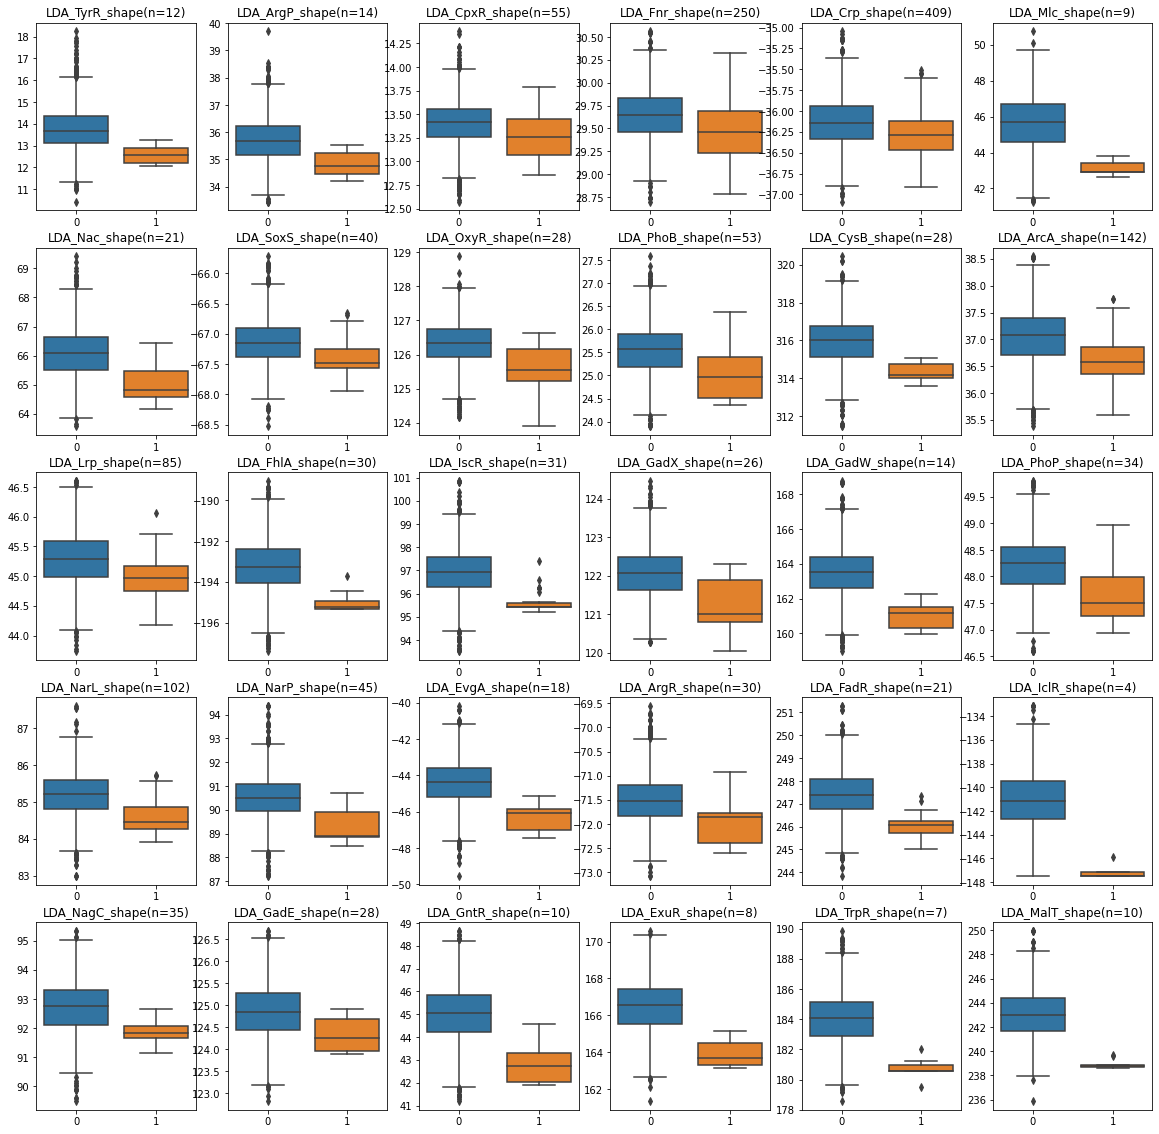

In [11]:
fig, axs = plt.subplots(5,6,figsize= (20,20))
for i in range(30):
    row_pos = int(i/6)
    col_pos = i - row_pos*6
    f_name = list( X_shape.keys() )[i]
    Xld = Xld_shape[f_name]
    if f_name == 'Crp':
        labels = list(regulon_labels['CRP'])
    elif f_name == 'Fnr':
        
        labels = list(regulon_labels['FNR'])
    else:
        labels = list(regulon_labels[f_name])
    
    sns.boxplot( labels,Xld, ax = axs[row_pos][col_pos] )
    axs[row_pos][col_pos].set_title('LDA_'+f_name+'_shape(n=' + str(sum(labels)) +')')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argumen

(0.0, 1.0, 0.0, 1.0)

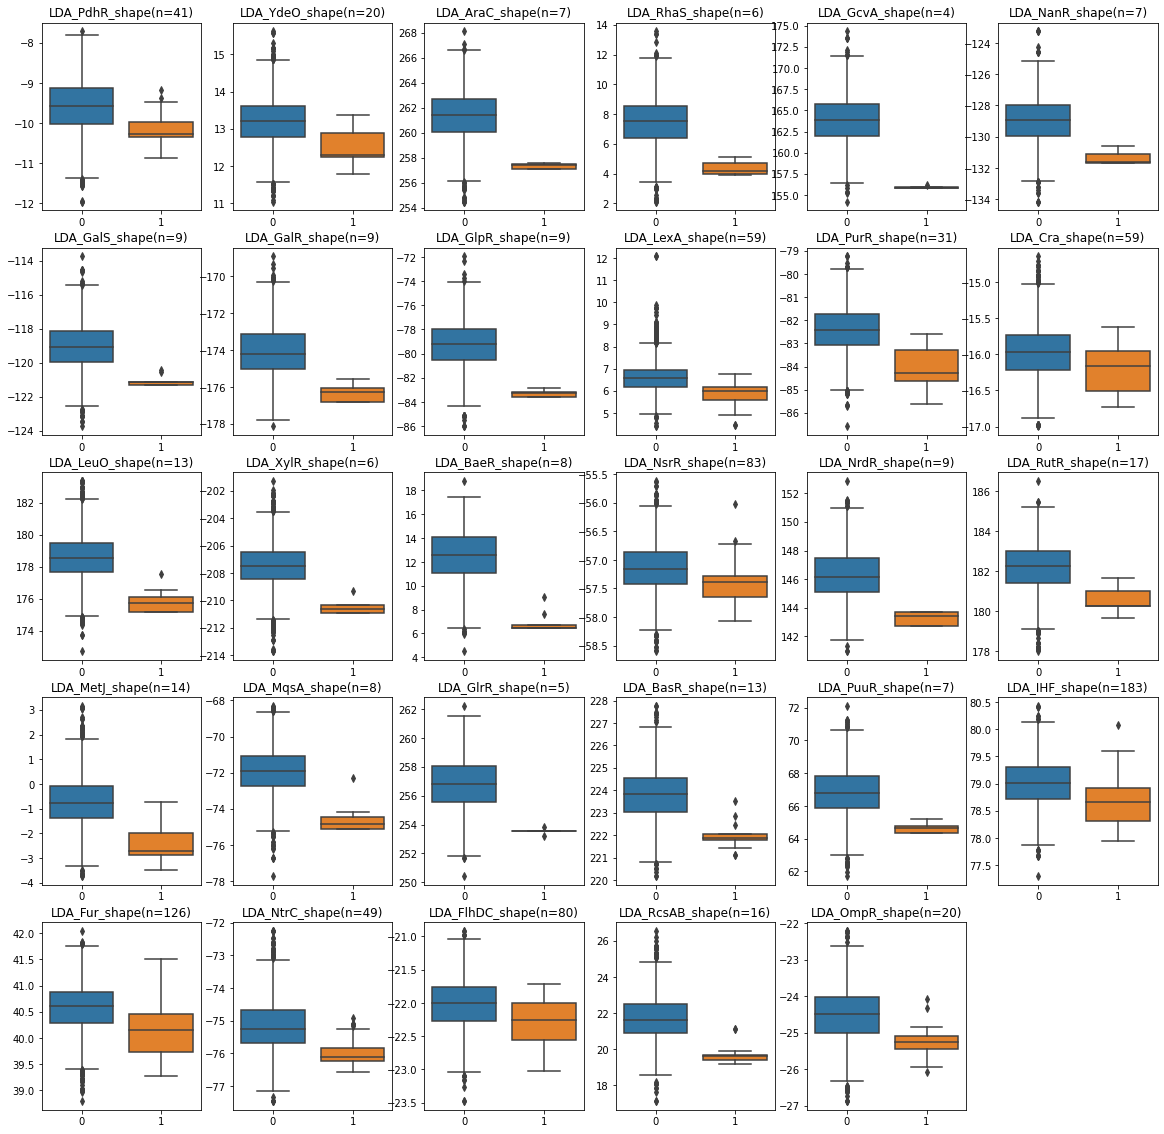

In [12]:
fig, axs = plt.subplots(5,6,figsize= (20,20))
for i in range(30,59):
    row_pos = int((i-30)/6)
    col_pos = (i-30) - row_pos*6
    f_name = list( X_shape.keys() )[i]
    Xld = Xld_shape[f_name]
    if f_name == 'Crp':
        labels = list(regulon_labels['CRP'])
    elif f_name == 'Fnr':
        
        labels = list(regulon_labels['FNR'])
    else:
        labels = list(regulon_labels[f_name])
    
    sns.boxplot( labels,Xld, ax = axs[row_pos][col_pos] )
    axs[row_pos][col_pos].set_title('LDA_'+f_name+'_shape(n=' + str(sum(labels)) +')')
    
axs[-1][-1].axis('off') 

## load sigma LDA and PSSM values to form a more concise table

In [11]:
eng_features = pd.DataFrame(Xld_shape)
eng_features.columns = [ n+'_shape_ld' for n in Xld_shape.keys()]

X_ld_sigma = {}
w_sigma = {'Sigma70': np.array([ 1.65064382e-02, -6.59506008e-02,  3.02672899e-01, -5.24886433e-02,
        1.71139291e-02, -5.81206469e-02,  1.50473443e-01, -6.07490918e-04,
       -6.33659058e-01,  1.83387202e-01]), 'Sigma38': np.array([-0.01371682, -0.20837012, -0.01447272, -0.08668739, -0.01633375,
        0.06734916, -0.07138144,  0.00261692, -0.543808  ,  0.58861234]), 'Sigma32': np.array([ 0.04611459, -0.27112878,  0.78284334, -0.03343359,  0.03332323,
       -0.13342375,  0.0499618 ,  0.01279136,  0.89601573, -1.3806742 ]), 'Sigma24': np.array([ 0.00797833, -0.11419877,  0.09339727, -0.06414143,  0.03343402,
       -0.16363185,  0.25952174, -0.02545569, -0.45804491,  0.98356359]), 'Sigma28': np.array([-0.03337679, -0.44776207,  0.83001936, -0.14254413,  0.0937775 ,
        0.02082157,  0.9029926 , -0.12715429, -5.67666246,  2.79836743]), 'Sigma54': np.array([ 0.00849921, -0.29833907,  0.19381744, -0.14867898, -0.1209861 ,
       -0.55674056,  0.08177916,  0.1294853 ,  2.10054191, -1.99187276])}

for signame in w_sigma.keys():
    temp = features[[signame + '_Prib_Start', signame + '_Prib_score',
       signame + '_Prib_hmd', signame + '_Prib_Tm', signame + '_m35_Start',
       signame + '_m35_score', signame +'_m35_hmd', signame +'_Spacer_Length',
       signame +'_Spacer_AT_ratio', signame + '_hepta_ratio']].iloc[:,:].values
    
    Xld_temp = []
    for v in temp:
        Xld_temp.append(  np.matmul( w_sigma[ signame ] , v) )
    X_ld_sigma[ signame ] = Xld_temp
    eng_features[signame + '_LD'] = Xld_temp
    
for r in motif_list:
    f_name = r
    if f_name == 'FNR':
        f_name = 'Fnr'
    if f_name == 'CRP':
        f_name = 'Crp'
        
    eng_features[f_name+' score'] = features[f_name+' score']

In [12]:
eng_features.columns

Index(['TyrR_shape_ld', 'ArgP_shape_ld', 'CpxR_shape_ld', 'Fnr_shape_ld',
       'Crp_shape_ld', 'Mlc_shape_ld', 'Nac_shape_ld', 'SoxS_shape_ld',
       'OxyR_shape_ld', 'PhoB_shape_ld',
       ...
       'OxyR im score', 'XylR im score', 'CysB-2 im score', 'ArgP im score',
       'CpxR im score', 'SoxS im score', 'Cra im score', 'Fur-1 im score',
       'PhoP im score', 'ArgR im score'],
      dtype='object', length=166)

# use new clf with LDAs

In [15]:
X_eng = eng_features.iloc[:,:].values
X_eng = StandardScaler().fit_transform(X_eng)

In [16]:
y_to_try = {
    'AllR':target_labels['AllR'],
    'ArcA':target_labels['ArcA'],
    'ArgR':target_labels['ArgR'],
    'ArgP':target_labels['ArgP'],
    'BaeR+CpxR':target_labels['BaeR+CpxR'],
    'CpxR':target_labels['CpxR'],
    'CdaR':target_labels['CdaR'],
    'Cra':target_labels['Cra'],
    'Crp-related-2':target_labels['Crp-related-2'],
    'EvgA':target_labels['EvgA'],
    'CysB-1':target_labels['CysB-1'],
    'CysB-2':target_labels['CysB-2'],
    'CysB-3':target_labels['CysB-3'],
    'FadR':target_labels['FadR'],
    'FlhDC-1':target_labels['FlhDC-1'],
    'FlhDC-2':target_labels['FlhDC-2'],
    'Fimbriae':target_labels['Fimbriae']
}

In [17]:
models_to_try = {
    'LR': LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        random_state=42
    ),
    'SVM': LinearSVC(
        penalty='l1',
        class_weight='balanced',
        dual=False,
        random_state=42,
        verbose=1
    ),
    'RF': RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        verbose=1
    )
}

In [18]:
result_df = pd.DataFrame(
    columns=['model', 'im', 'train_auc', 'test_auc']
)

N_CV = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for y_name, y_labels in y_to_try.items():
        print(f'{model_name}: {y_name}')
        
        cv_result = cross_validate(
            model,
            X_eng,
            y= y_labels,
            cv=N_CV,
            scoring='roc_auc',
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'im': [y_name] * N_CV,
                'train_auc': cv_result['train_score'],
                'test_auc': cv_result['test_score']
            }
        )

        result_df = result_df.append(sub_result_df)
        
result_df.to_csv('data/model_selection_shapeLD.csv')

LR
LR: AllR


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: ArcA


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: ArgR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: ArgP


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: BaeR+CpxR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: CpxR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: CdaR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: Cra


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: Crp-related-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: EvgA


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: CysB-1


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: CysB-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: CysB-3


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: FadR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: FlhDC-1


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: FlhDC-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: Fimbriae


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM
SVM: AllR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: ArcA


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: ArgR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: ArgP


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: BaeR+CpxR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: CpxR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: CdaR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: Cra


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: Crp-related-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: EvgA


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: CysB-1


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: CysB-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: CysB-3


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: FadR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: FlhDC-1


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: FlhDC-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: Fimbriae


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF
RF: AllR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: ArcA


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: ArgR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: ArgP


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: BaeR+CpxR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: CpxR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: CdaR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: Cra


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: Crp-related-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: EvgA


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: CysB-1


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: CysB-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: CysB-3


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: FadR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: FlhDC-1


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: FlhDC-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: Fimbriae


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.0s finished


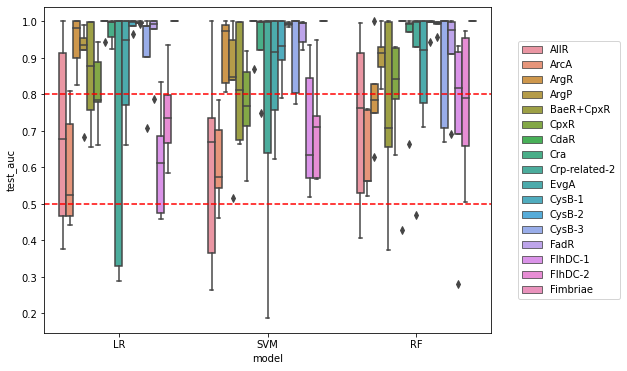

In [19]:
result_df = pd.read_csv('data/model_selection_shapeLD.csv')
_, ax = plt.subplots(figsize= (8,6))
sns.boxplot(x='model', y='test_auc', data=result_df, hue='im', dodge=True, ax=ax)
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')

In [21]:
hyperopt_models = {
    'LR': {
        'model': LogisticRegression(
            solver='liblinear',
            class_weight='balanced',
            verbose=1
        ),
        'param_dists': {
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-1,2,15),
            'max_iter':np.array([2000])
        }
    }
}

### Logit Regression

In [22]:
hyperopt_LR = {}

for y_name, y_labels in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['LR']['model'],
        hyperopt_models['LR']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(  X_eng ,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_LR[y_name] = hyperopt_results_df
    
# combine all the hyperopt results into a DF
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_LR.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)

hyperopt_LR_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)
hyperopt_LR_df.to_csv('data/hyperopt_LR_engfeature0.csv')

AllR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    9.7s remaining:    0.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]ArcA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   24.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]ArgR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]ArgP
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   43.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]BaeR+CpxR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    8.6s finished


[LibLinear]CpxR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   22.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]CdaR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]Cra
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]Crp-related-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    5.1s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]EvgA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]CysB-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    9.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]CysB-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  73 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]CysB-3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   13.6s finished


[LibLinear]FadR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]FlhDC-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   38.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]FlhDC-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    8.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]Fimbriae
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    3.8s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    3.9s finished


[LibLinear]

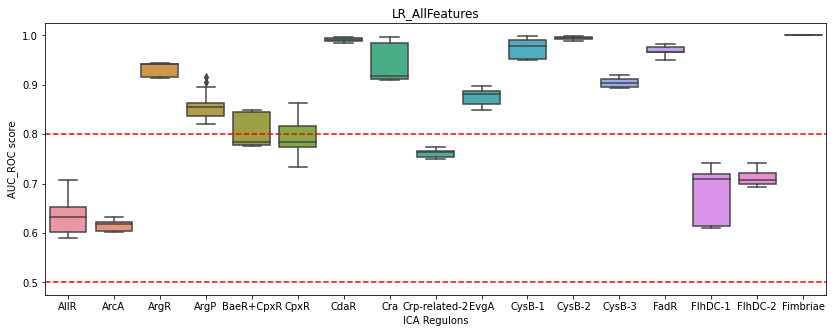

In [23]:
hyperopt_result_df = pd.read_csv( 'data/hyperopt_LR_engfeature0.csv' , index_col=0)
plt.figure( figsize=(14,5))
#sns.swarmplot(x='im', y='mean_train_score', data=hyperopt_result_df)
sns.boxplot(x='im', y='mean_test_score', data=hyperopt_result_df)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('AUC_ROC score')
plt.xlabel('ICA Regulons')
plt.title('LR_AllFeatures')
plt.savefig('../../thesis_plots/IM_ML_performance0.svg',dpi=150)

In [24]:
y_to_try_3 = {
    'PuuR':target_labels['PuuR'],'RcsAB':target_labels['RcsAB'], 'RhaS':target_labels['RhaS'],
    'RpoE':target_labels['RpoE'], 'RpoH':target_labels['RpoH'], 'RpoN+FhlA':target_labels['RpoN+FhlA'],
    'RpoN+NtrC-1':target_labels['RpoN+NtrC-1'],'RpoN+NtrC-2':target_labels['RpoN+NtrC-2'],
    'RpoN+PrpR+Cra':target_labels['RpoN+PrpR+Cra'],'RpoN+PspF':target_labels['RpoN+PspF'],
    'RpoS':target_labels['RpoS'],'RpoS+ArgR+RpoN':target_labels['RpoS+ArgR+RpoN'],'RutR':target_labels['RutR'],
    'SoxS':target_labels['SoxS'],'TrpR':target_labels['TrpR'],'TyrR':target_labels['TyrR'],
    'XylR':target_labels['XylR'],'YdeO+H-NS':target_labels['YdeO+H-NS']
}

In [25]:
hyperopt_LR = {}

for y_name, y_labels in y_to_try_3.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['LR']['model'],
        hyperopt_models['LR']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(  X_eng ,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_LR[y_name] = hyperopt_results_df
    
# combine all the hyperopt results into a DF
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_LR.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)

hyperopt_LR_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)
hyperopt_LR_df.to_csv('data/hyperopt_LR_engfeature3.csv')

PuuR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    5.2s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    5.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]RcsAB
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]RhaS
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    6.9s remaining:    0.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]RpoE
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   13.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]RpoH
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   23.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]RpoN+FhlA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]RpoN+NtrC-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]RpoN+NtrC-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   14.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]RpoN+PrpR+Cra
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    7.8s remaining:    0.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    7.9s finished


[LibLinear]RpoN+PspF
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]RpoS
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   37.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  2.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]RpoS+ArgR+RpoN
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:   10.7s remaining:    0.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   13.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]RutR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   13.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]SoxS
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 38.9min finished


[LibLinear]TrpR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]TyrR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:   10.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   10.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]XylR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    4.8s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]YdeO+H-NS
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    6.7s finished


[LibLinear]

Text(0.5, 1.0, 'LR_AllFeatures')

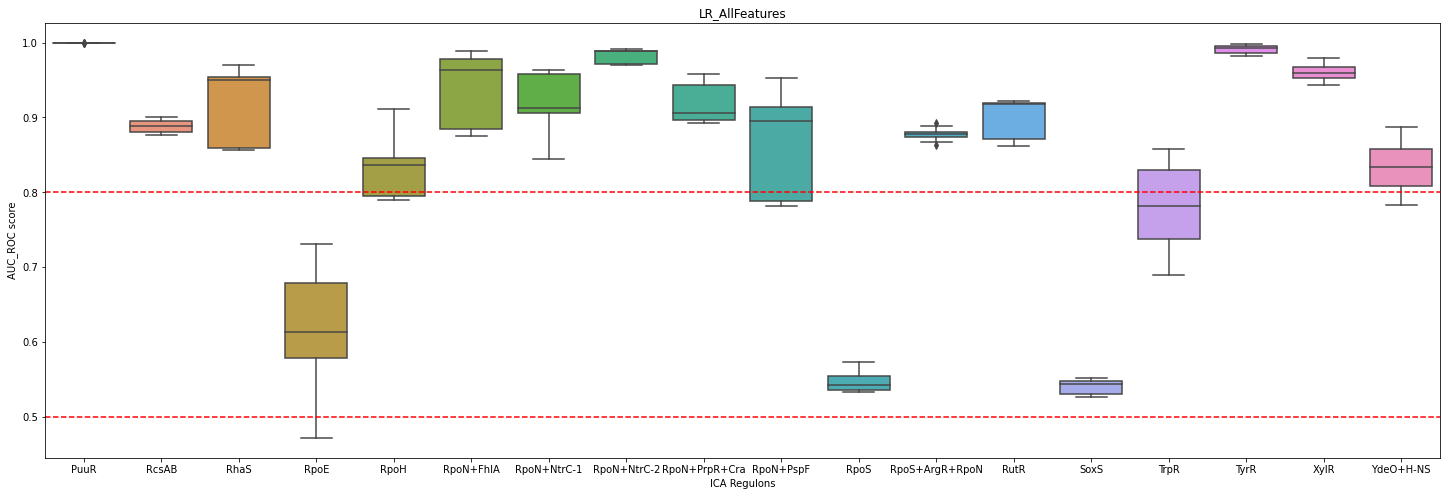

In [26]:
hyperopt_result_df = pd.read_csv( 'data/hyperopt_LR_engfeature3.csv' , index_col=0)
plt.figure( figsize=(25,8))
#sns.swarmplot(x='im', y='mean_train_score', data=hyperopt_result_df)
sns.boxplot(x='im', y='mean_test_score', data=hyperopt_result_df)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('AUC_ROC score')
plt.xlabel('ICA Regulons')
plt.title('LR_AllFeatures')

(0.45, 1.05)

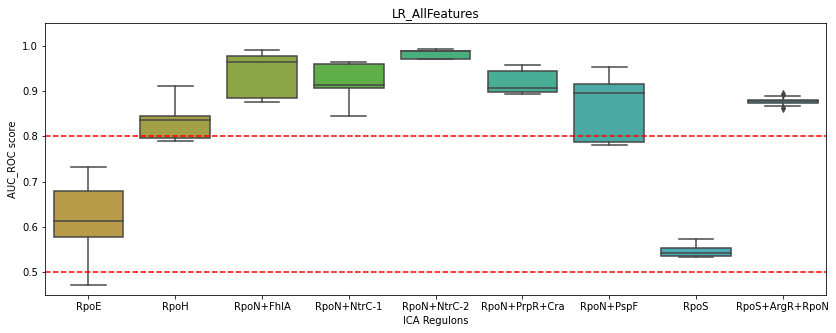

In [27]:
hyperopt_result_df = pd.read_csv( 'data/hyperopt_LR_engfeature3.csv' , index_col=0)
fig = plt.figure( figsize=(14,5))
#sns.swarmplot(x='im', y='mean_train_score', data=hyperopt_result_df)
sns.boxplot(x='im', y='mean_test_score', data=hyperopt_result_df)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('AUC_ROC score')
plt.xlabel('ICA Regulons')
plt.title('LR_AllFeatures')
plt.xlim([2.5,11.5])
plt.ylim([0.45,1.05])

In [28]:
y_to_try_1 = {
    'Fnr+IHF+gcvB':target_labels['Fnr+IHF+gcvB'], 'Fnr+NarL':target_labels['Fnr+NarL'],
    'Fnr+NarLP':target_labels['Fnr+NarLP'],'Fnr-1':target_labels['Fnr-1'],'Fnr-2':target_labels['Fnr-2'],
    'Fur-1':target_labels['Fur-1'], 'Fur-2':target_labels['Fur-2'],'GadE+FliZ':target_labels['GadE+FliZ'],
    'GadX':target_labels['GadX'], 'GalRS':target_labels['GalRS'],'GatR':target_labels['GatR'],
    'GlpR':target_labels['GlpR'], 'GntR':target_labels['GntR'],
    'Leucine':target_labels['Leucine'],'LexA':target_labels['LexA']
}

In [29]:
hyperopt_LR = {}

for y_name, y_labels in y_to_try_1.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['LR']['model'],
        hyperopt_models['LR']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(  X_eng ,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_LR[y_name] = hyperopt_results_df
    
# combine all the hyperopt results into a DF
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_LR.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)

hyperopt_LR_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)
hyperopt_LR_df.to_csv('data/hyperopt_LR_engfeature1.csv')

Fnr+IHF+gcvB
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]Fnr+NarL
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   18.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]Fnr+NarLP
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    6.0s remaining:    0.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]Fnr-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   25.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]Fnr-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]Fur-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   16.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]Fur-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   18.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]GadE+FliZ
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]GadX
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]GalRS
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    5.4s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]GatR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]GlpR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]GntR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]Leucine
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    5.0s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    5.2s finished


[LibLinear]LexA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    6.9s finished


[LibLinear]

Text(0.5, 1.0, 'LR_AllFeatures')

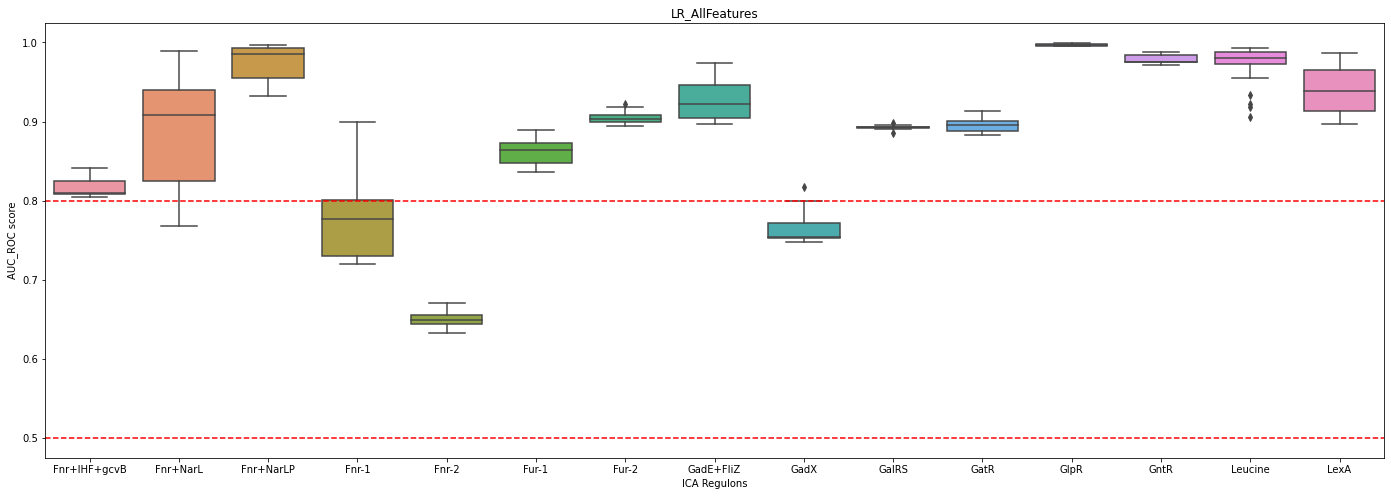

In [30]:
hyperopt_result_df = pd.read_csv( 'data/hyperopt_LR_engfeature1.csv' , index_col=0)
plt.figure( figsize=(24,8))
#sns.swarmplot(x='im', y='mean_train_score', data=hyperopt_result_df)
sns.boxplot(x='im', y='mean_test_score', data=hyperopt_result_df)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('AUC_ROC score')
plt.xlabel('ICA Regulons')
plt.title('LR_AllFeatures')

In [31]:
y_to_try_2 = {
    'OxyR':target_labels['OxyR'], 'LexA':target_labels['LexA'],'NsrR':target_labels['NsrR'],
    'Lrp':target_labels['Lrp'],'MalT':target_labels['MalT'],'Mlc':target_labels['Mlc'],
    'MetJ':target_labels['MetJ'],'Nac':target_labels['Nac'], 'NagC':target_labels['NagC'],
    'NanR':target_labels['NanR'], 'NarL':target_labels['NarL'],'NrdR':target_labels['NrdR'],
    'PaaX':target_labels['PaaX'],'PhoB-1':target_labels['PhoB-1'],'PhoB-2':target_labels['PhoB-2'],
    'PhoP':target_labels['PhoP'],'PurR-1':target_labels['PurR-1'],'PurR-2':target_labels['PurR-2']
}

In [32]:
hyperopt_LR = {}

for y_name, y_labels in y_to_try_2.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['LR']['model'],
        hyperopt_models['LR']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(  X_eng ,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_LR[y_name] = hyperopt_results_df
    
# combine all the hyperopt results into a DF
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_LR.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)

hyperopt_LR_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)
hyperopt_LR_df.to_csv('data/hyperopt_LR_engfeature2.csv')

OxyR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]LexA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]NsrR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    8.3s remaining:    0.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    9.5s finished


[LibLinear]Lrp
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]MalT
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    5.0s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    5.2s finished


[LibLinear]Mlc
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]MetJ
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    4.9s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]Nac
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   24.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]NagC
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   14.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]NanR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]NarL
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   22.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]NrdR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    4.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    4.5s finished


[LibLinear]PaaX
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]PhoB-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    9.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]PhoB-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]PhoP
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    9.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]PurR-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   12.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]PurR-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s


[LibLinear]

[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    6.6s finished


Text(0.5, 1.0, 'LR_AllFeatures')

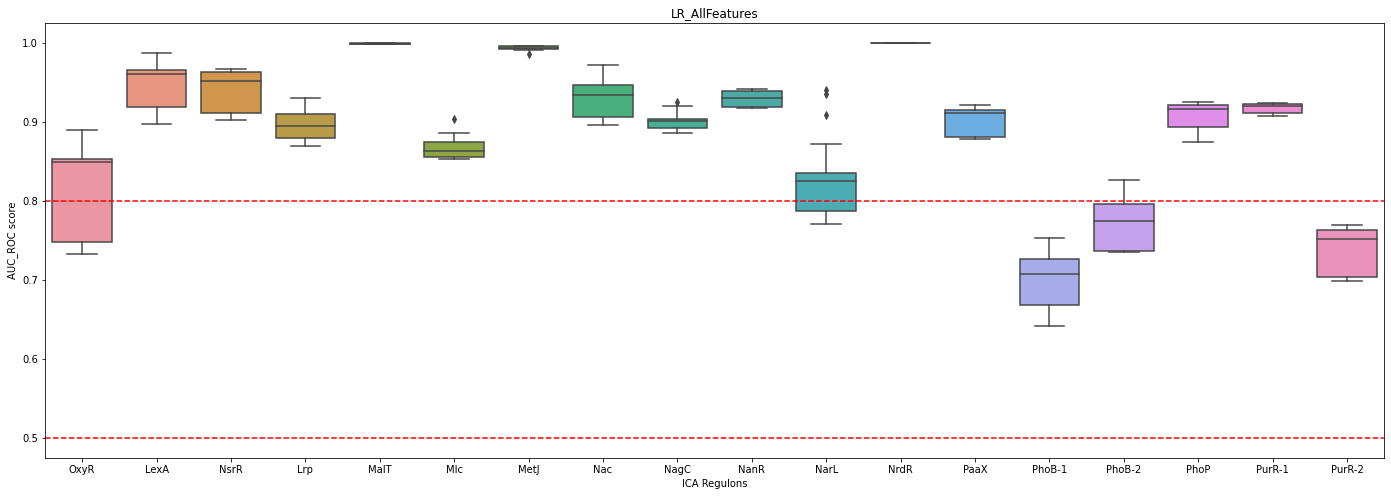

In [33]:
hyperopt_result_df = pd.read_csv( 'data/hyperopt_LR_engfeature2.csv' , index_col=0)
plt.figure( figsize=(24,8))
#sns.swarmplot(x='im', y='mean_train_score', data=hyperopt_result_df)
sns.boxplot(x='im', y='mean_test_score', data=hyperopt_result_df)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('AUC_ROC score')
plt.xlabel('ICA Regulons')
plt.title('LR_AllFeatures')

### check feature importances

In [15]:
import shap
from sklearn.model_selection import train_test_split
check_list = ['ArgR','ArgP','BaeR+CpxR','CdaR', 'Cra','EvgA', 'RpoH']
table0 = pd.read_csv( 'data/hyperopt_LR_engfeature0.csv' , index_col=0)
table3= pd.read_csv( 'data/hyperopt_LR_engfeature3.csv' , index_col=0)
hyperopt_result_df= pd.concat([table0,table3])

In [32]:
shap_vals= {}
X_fi = pd.DataFrame( X_eng, columns= eng_features.columns , index=eng_features.index)
for im in check_list:
    sub_table = hyperopt_result_df[ hyperopt_result_df['im']==im]
    sub_table = sub_table[sub_table['param_penalty'] == 'l1']
    sub_table = sub_table.sort_values(by='mean_test_score', ascending=False)
    params = ast.literal_eval( list(sub_table['params'])[0])
    clf = LogisticRegression(solver='saga',class_weight='balanced',verbose=1)
    clf.set_params( penalty = params['penalty'])
    clf.set_params( C = params['C'])
    clf.set_params( max_iter = params['max_iter'])
    if im =='RpoH':
        y = pd.Series(y_to_try_3[im] )
    else:
        y = pd.Series(y_to_try[im] )
    X_train, X_test, y_train, y_test = train_test_split( X_fi, y, test_size=0.3, random_state=7)
    clf.fit(X_train, y_train)
    explainer = shap.Explainer(clf, X_train )
    shap_vals[im] = explainer(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 9 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 9 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 8 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 7 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 9 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 9 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 10 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s finished


In [33]:
print(check_list)

['ArgR', 'ArgP', 'BaeR+CpxR', 'CdaR', 'Cra', 'EvgA', 'RpoH']


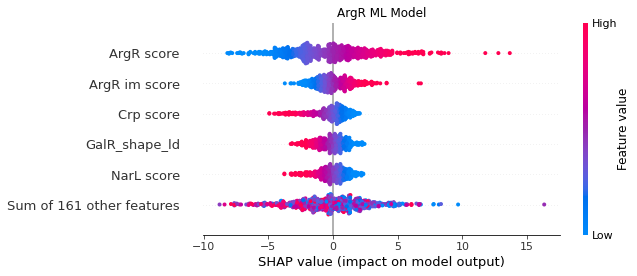

In [47]:
im_name = 'ArgR'
plt.title(im_name+" ML Model")
shap.plots.beeswarm( shap_vals[im_name],max_display=6,show = False)
plt.savefig('../../thesis_plots/'+im_name+'_features.svg',dpi=150)

In [28]:
def categoryToList( x, category ):
    result = {}
    for i in range(len(x)):
        if category[i] not in result.keys():
            result[ category[i] ] = [ x[i] ]
        else:
            result[ category[i] ].append( x[i] )
    return result

In [29]:
from scipy.stats import ttest_ind

In [107]:
result = categoryToList( features['ArgR im score'], y_to_try['ArgR'])
ttest_ind(result[0],result[1])

Ttest_indResult(statistic=-10.463141231483831, pvalue=4.0084739958485906e-25)

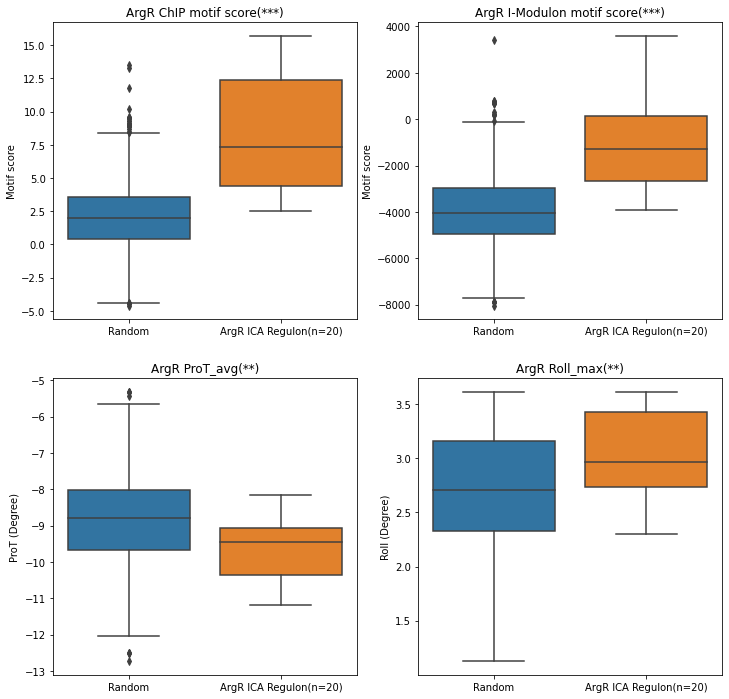

In [113]:
fig,axs = plt.subplots(2,2,figsize=(12,12))
what_to_plot = ['ArgR score','ArgR im score','ArgR ProT_avg','ArgR Roll_max']
for i in range(len(what_to_plot) ):
    temp_ax = axs[int(i/2)][int(i%2)]
    sns.boxplot( x= y_to_try['ArgR'],y=features[what_to_plot[i]],ax=temp_ax )
    temp_ax.set_xticklabels(['Random','ArgR ICA Regulon(n={num})'.format(num=sum(y_to_try['ArgR']))])
    temp_ax.set_title(what_to_plot[i]+'(**)')
axs[0][0].set_title("ArgR ChIP motif score(***)")
axs[0][1].set_title("ArgR I-Modulon motif score(***)")
axs[0][0].set_ylabel("Motif score")
axs[0][1].set_ylabel('Motif score')
axs[1][0].set_ylabel('ProT (Degree)')
axs[1][1].set_ylabel('Roll (Degree)')
fig.savefig('../../thesis_plots/ArgR_TFscore_shape.svg',dpi=150)

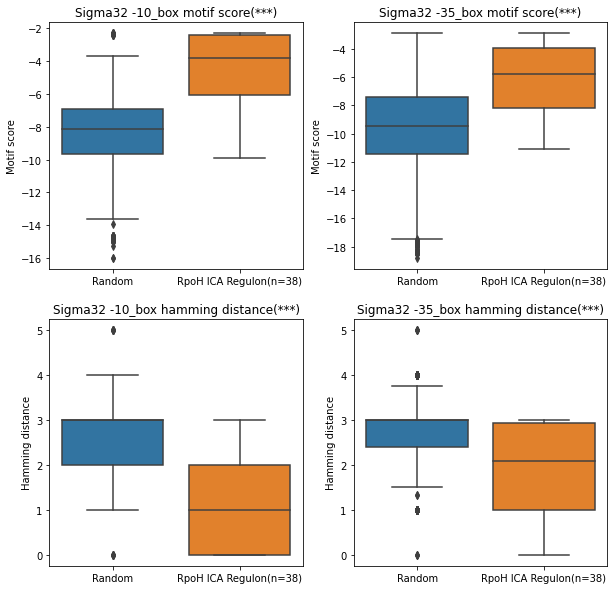

In [71]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
sns.boxplot( x= y_to_try_3['RpoH'],y=features['Sigma32_Prib_score'],ax=axs[0][0])
sns.boxplot( x= y_to_try_3['RpoH'],y=features['Sigma32_m35_score'],ax=axs[0][1] )
sns.boxplot( x= y_to_try_3['RpoH'],y=features['Sigma32_Prib_hmd'],ax=axs[1][0] )
sns.boxplot( x= y_to_try_3['RpoH'],y=features['Sigma32_m35_hmd'],ax=axs[1][1] )
for ax in axs:
    for a in ax:
        a.set_xticklabels(['Random','RpoH ICA Regulon(n={num})'.format(num=sum(y_to_try_3['RpoH']))])
axs[0][0].set_title("Sigma32 -10_box motif score(***)")
axs[0][0].set_ylabel("Motif score")
axs[0][1].set_title("Sigma32 -35_box motif score(***)")
axs[0][1].set_ylabel("Motif score")
axs[1][0].set_title("Sigma32 -10_box hamming distance(***)")
axs[1][0].set_ylabel("Hamming distance")
axs[1][1].set_title("Sigma32 -35_box hamming distance(***)")
axs[1][1].set_ylabel("Hamming distance")
fig.savefig('../../thesis_plots/RpoH_pribnow_scores.svg',dpi=150)

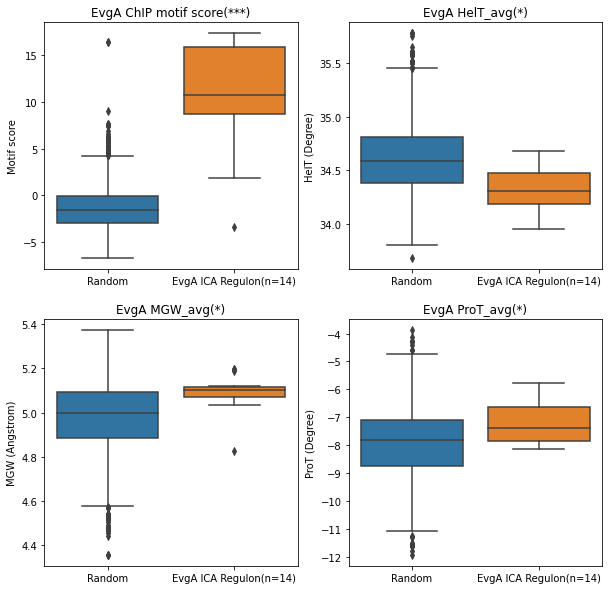

In [108]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
what_to_plot = ['EvgA score','EvgA HelT_avg','EvgA MGW_avg','EvgA ProT_avg']
for i in range(len(what_to_plot) ):
    temp_ax = axs[int(i/2)][int(i%2)]
    sns.boxplot( x= y_to_try['EvgA'],y=features[what_to_plot[i]],ax=temp_ax )
    temp_ax.set_xticklabels(['Random','EvgA ICA Regulon(n={num})'.format(num=sum(y_to_try['EvgA']))])
    temp_ax.set_title(what_to_plot[i]+'(*)')
axs[0][0].set_title("EvgA ChIP motif score(***)")
axs[0][0].set_ylabel("Motif score")
axs[0][1].set_ylabel('HelT (Degree)')
axs[1][0].set_ylabel('MGW (Angstrom)')
axs[1][1].set_ylabel('ProT (Degree)')
fig.savefig('../../thesis_plots/EvgA_TFscore_shape.svg',dpi=150)

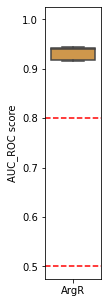

In [20]:
table0 = pd.read_csv( 'data/hyperopt_LR_engfeature0.csv' , index_col=0)
table3= pd.read_csv( 'data/hyperopt_LR_engfeature3.csv' , index_col=0)
plt.figure(figsize=(1,5))
sns.boxplot(x='im', y='mean_test_score', data=table0)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('AUC_ROC score')
plt.xlabel('')
plt.xlim([1.5,2.5])
plt.savefig('../../thesis_plots/ArgR_aucroc.svg',dpi=150)

### Fnr case study

In [34]:
fnrs = {
    'Fnr+IHF+gcvB':target_labels['Fnr+IHF+gcvB'], 'Fnr+NarL':target_labels['Fnr+NarL'],
    'Fnr+NarLP':target_labels['Fnr+NarLP'],'Fnr-1':target_labels['Fnr-1'],'Fnr-2':target_labels['Fnr-2']
}


hyperopt_LR = {}

for y_name, y_labels in fnrs.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['LR']['model'],
        hyperopt_models['LR']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(  X_eng ,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_LR[y_name] = hyperopt_results_df
    
# combine all the hyperopt results into a DF
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_LR.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)

hyperopt_LR_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)

Fnr+IHF+gcvB
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]Fnr+NarL
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   18.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]Fnr+NarLP
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]Fnr-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   28.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]Fnr-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.0s


[LibLinear]

[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.0min finished


Text(0, 0.5, 'AUC_ROC score')

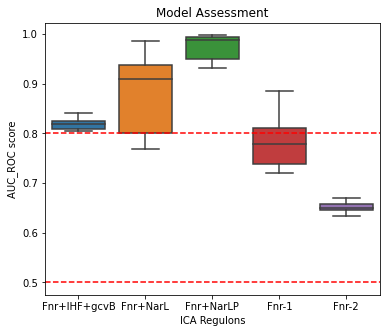

In [35]:
#sns.swarmplot(x='im', y='mean_train_score', data= hyperopt_LR_df)
fig = plt.figure(figsize=(6,5))
sns.boxplot(x='im', y='mean_test_score', data= hyperopt_LR_df)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.title('Model Assessment')
plt.xlabel('ICA Regulons')
plt.ylabel('AUC_ROC score')

In [24]:
f_eng_list = list(eng_features.columns)
f_importance_table = {}
for im in fnrs.keys():
    sub_table = hyperopt_LR_df[ hyperopt_LR_df['im']==im]
    sub_table = sub_table[sub_table['param_penalty'] == 'l1']
    sub_table = sub_table.sort_values(by='mean_test_score', ascending=False)
    params = list(sub_table['params'])[0]
    clf = LogisticRegression(solver='liblinear',class_weight='balanced',verbose=1,max_iter=1000)
    clf.set_params( penalty = params['penalty'])
    clf.set_params( C = params['C'])
    clf.fit( X_eng ,fnrs[im] )
    weight = [ ( f_eng_list[i],   round(clf.coef_[0][i],4 )  ) for i in range(len(clf.coef_[0]))]
    top_5 = sorted(weight, key=lambda tup: tup[1],reverse=True)[:8]
    last_5 = sorted(weight, key=lambda tup: tup[1],reverse=False)[:8]
    f_importance_table[im] = pd.DataFrame(zip(top_5,last_5),columns=[im+'_LR_coef(+)',im+'_LR_coef(-)'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


In [23]:
f_importance_table.keys()

dict_keys(['Fnr+IHF+gcvB', 'Fnr+NarL', 'Fnr+NarLP', 'Fnr-1', 'Fnr-2'])

In [36]:
import shap
from sklearn.model_selection import train_test_split
f_eng_list = list(eng_features.columns)

In [37]:
shap_vals= {}
X_fi = pd.DataFrame( X_eng, columns= eng_features.columns , index=eng_features.index)
for im in fnrs.keys():
    sub_table = hyperopt_LR_df[ hyperopt_LR_df['im']==im]
    sub_table = sub_table[sub_table['param_penalty'] == 'l1']
    sub_table = sub_table.sort_values(by='mean_test_score', ascending=False)
    params = list(sub_table['params'])[0]
    clf = LogisticRegression(solver='saga',class_weight='balanced',verbose=1,max_iter=1000)
    clf.set_params( penalty = params['penalty'])
    clf.set_params( C = params['C'])
    y = pd.Series( fnrs[im] )
    X_train, X_test, y_train, y_test = train_test_split( X_fi, y, test_size=0.3, random_state=7)
    clf.fit(X_train, y_train)
    explainer = shap.Explainer(clf, X_train )
    shap_vals[im] = explainer(X_test) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds


The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


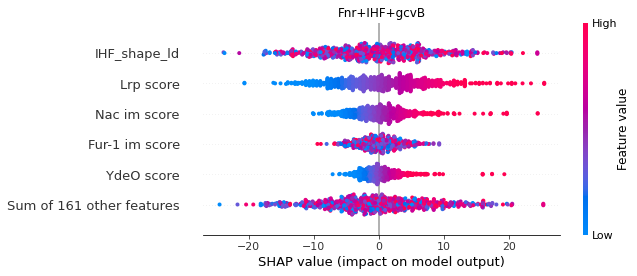

In [80]:
plt.title('Fnr+IHF+gcvB')
shap.plots.beeswarm(shap_vals['Fnr+IHF+gcvB'],max_display=6)

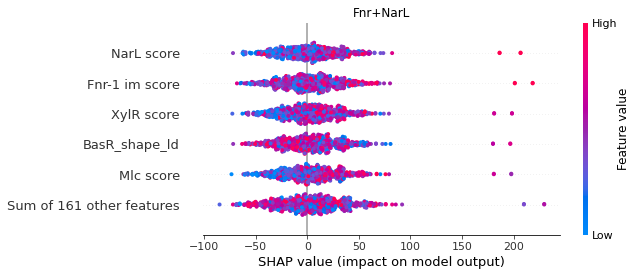

In [86]:
plt.title('Fnr+NarL')
shap.plots.beeswarm(shap_vals['Fnr+NarL'],max_display=6)

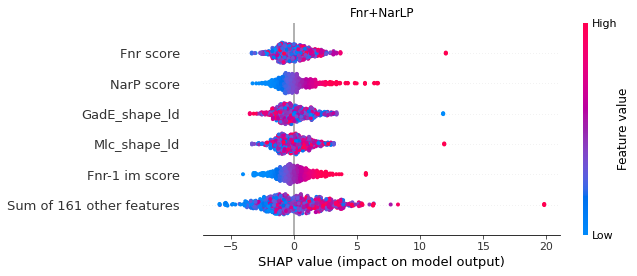

In [87]:
plt.title('Fnr+NarLP')
shap.plots.beeswarm(shap_vals['Fnr+NarLP'],max_display=6)

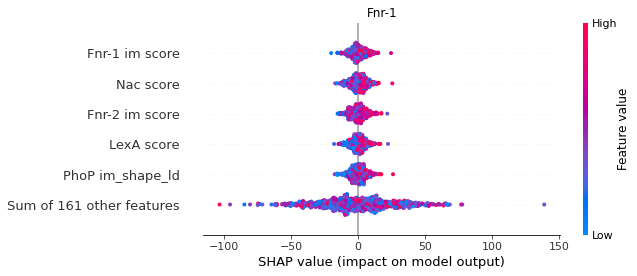

In [88]:
plt.title('Fnr-1')
shap.plots.beeswarm(shap_vals['Fnr-1'],max_display=6)

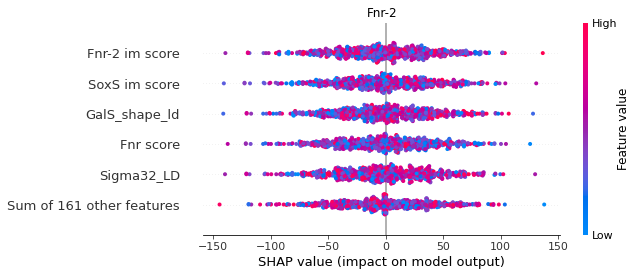

In [94]:
plt.title('Fnr-2')
shap.plots.beeswarm(shap_vals['Fnr-2'],max_display=6)

In [95]:
fnr_ims = ['Fnr+IHF+gcvB', 'Fnr+NarL', 'Fnr+NarLP', 'Fnr-1', 'Fnr-2']
fnr_ihf=[]
fnr_ihf_shape = []
fnr1score = []
fnr2score = []
fnrscore = []
fnr_shape = []
fnr_narl = []
fnr_narp = []
fnr_narl_shape = []
fnr_narp_shape = []
fnr_category = []
for k in fnr_ims:
    for i in range(len(ID)):
        if ID[i] in IM_genes[k]:
            fnr_category.append(k)
            fnr_ihf.append( eng_features['IHF score'][i] )
            fnr_ihf_shape.append( eng_features['IHF_shape_ld'][i] )
            fnr1score.append(  eng_features['Fnr-1 im score'][i]  )
            fnr2score.append(  eng_features['Fnr-2 im score'][i]  )
            fnrscore.append(  eng_features['Fnr score'][i]  )
            fnr_shape.append(  eng_features['Fnr_shape_ld'][i]  )
            fnr_narl.append( eng_features['NarL score'][i] )
            fnr_narp.append( eng_features['NarP score'][i] )
            fnr_narl_shape.append( eng_features['NarL_shape_ld'][i])
            fnr_narp_shape.append( eng_features['NarP_shape_ld'][i])
            
import random
for i in range(200):
    rand_index = random.randint(100,2000)
    fnr_category.append('Random')
    fnr_ihf.append( eng_features['IHF score'][rand_index] )
    fnr_ihf_shape.append( eng_features['IHF_shape_ld'][rand_index] )
    fnr1score.append(  eng_features['Fnr-1 im score'][rand_index]  )
    fnr2score.append(  eng_features['Fnr-2 im score'][rand_index]  )
    fnrscore.append(  eng_features['Fnr score'][rand_index]  )
    fnr_shape.append(  eng_features['Fnr_shape_ld'][rand_index]  )
    fnr_narl.append( eng_features['NarL score'][rand_index] )
    fnr_narp.append( eng_features['NarP score'][rand_index] )
    fnr_narl_shape.append( eng_features['NarL_shape_ld'][rand_index])
    fnr_narp_shape.append( eng_features['NarP_shape_ld'][rand_index])

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


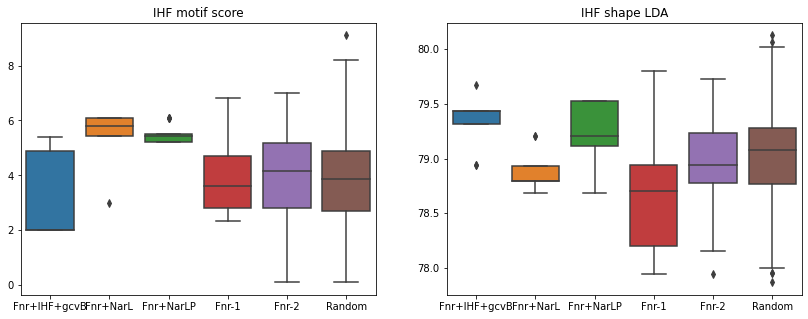

In [96]:
titles = ['IHF motif score','IHF shape LDA', 'Fnr-1 IM motif score','Fnr-2 IM motif score','Fnr motif score','Fnr shape LDA',
         'NarL motif score','NarP motif score','NarL shape LDA','NarP shape LDA']
fnr_features = [fnr_ihf,fnr_ihf_shape,fnr1score,fnr2score,fnrscore,fnr_shape,
                fnr_narl, fnr_narp, fnr_narl_shape, fnr_narp_shape ]

fig, axs = plt.subplots(1,2,figsize= (14,5))
for i in range(2):
    sns.boxplot( fnr_category, fnr_features[i], ax = axs[i] )
    axs[i].set_title(titles[i])

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argumen

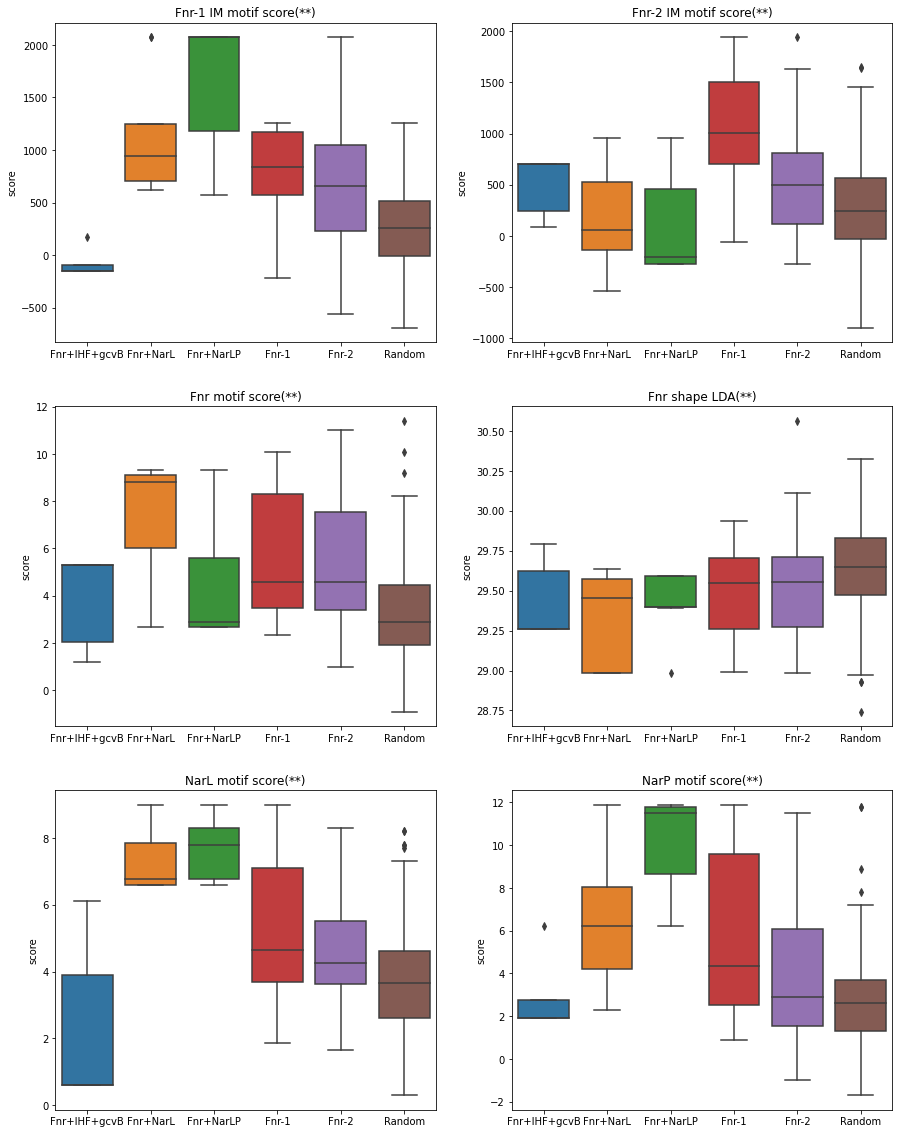

In [97]:
fig, axs = plt.subplots(3,2,figsize= (15,20))
for i in range(2,8):
    x_axis = (i-2)%2
    y_axis = int( (i-2)/2 )
    sns.boxplot( fnr_category, fnr_features[i], ax = axs[y_axis][x_axis] )
    axs[y_axis][x_axis].set_title(titles[i]+'(**)')
    axs[y_axis][x_axis].set_ylabel('score')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


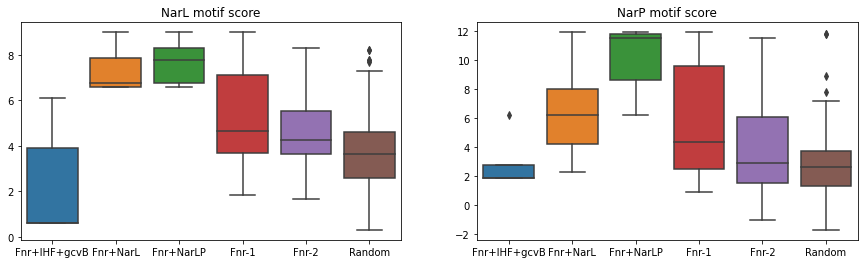

In [98]:
fig, axs = plt.subplots(1,2,figsize= (15,4))
for i in range(6,8):
    index = i -6
    sns.boxplot( fnr_category, fnr_features[i], ax = axs[index] )
    axs[index].set_title(titles[i])

In [99]:
def categoryToList( x, category ):
    result = {}
    for i in range(len(x)):
        if category[i] not in result.keys():
            result[ category[i] ] = [ x[i] ]
        else:
            result[ category[i] ].append( x[i] )
    return result

In [100]:
from scipy.stats import f_oneway
for i in range(2,8):
    result = categoryToList( fnr_features[i], fnr_category)
    p = f_oneway(result['Fnr+IHF+gcvB'],result['Fnr+NarL'],result['Fnr+NarLP'],result['Fnr-1'],result['Fnr-2'],result['Random']).pvalue
    print(p)

1.893189322712936e-38
2.267424983563215e-16
1.2768591913686385e-13
5.559392503558648e-06
2.3684104067479843e-28
1.9078419887085233e-36


<AxesSubplot:>

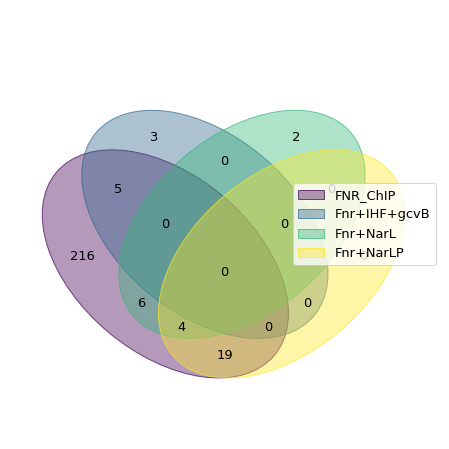

In [25]:
from venn import venn
from venn import venn4
sets = {'FNR_ChIP': set(regulon_genes['FNR']), 'Fnr+IHF+gcvB':set(IM_genes['Fnr+IHF+gcvB']), 'Fnr+NarL':set(IM_genes['Fnr+NarL']),
        'Fnr+NarLP':set(IM_genes['Fnr+NarLP'])}
    
venn(sets,legend_loc="right")

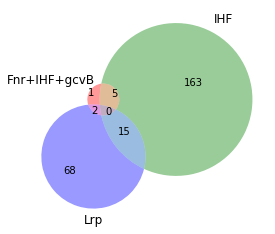

In [55]:
from matplotlib_venn import venn2,venn3

venn3( [set(IM_genes['Fnr+IHF+gcvB']),set(regulon_genes['IHF']),set(regulon_genes['Lrp'])],
      set_labels = ('Fnr+IHF+gcvB','IHF','Lrp') )

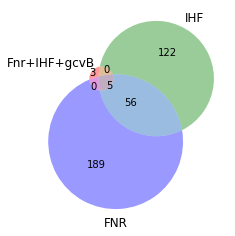

In [57]:
venn3( [set(IM_genes['Fnr+IHF+gcvB']),set(regulon_genes['IHF']),set(regulon_genes['FNR'])],
      set_labels = ('Fnr+IHF+gcvB','IHF','FNR') )

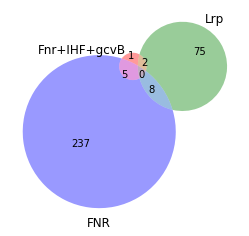

In [58]:
venn3( [set(IM_genes['Fnr+IHF+gcvB']),set(regulon_genes['Lrp']),set(regulon_genes['FNR'])],
      set_labels = ('Fnr+IHF+gcvB','Lrp','FNR') )

## compare scores in IM and regulon

In [133]:
import random
IMs_to_check = ['ArgR','Cra','EvgA','NarL','CysB-1','CysB-2']
data = {}
for im in IMs_to_check:
    data[im] = {'category':[],'score':[]}
    if im in ['CysB-1','CysB-2']:
        chip_name = im[0:4]
    else:
        chip_name = im
        
    for i in range(len(ID)):
        if ID[i] in set(regulon_genes[chip_name])&set(IM_genes[im]):
            data[im]['category'].append( 'Overlap')
            data[im]['score'].append( eng_features[ chip_name+' score'][i])
        if ID[i] in set(IM_genes[im]) - set(regulon_genes[chip_name]):
            data[im]['category'].append( 'ICA_Regulon(unique)')
            data[im]['score'].append( eng_features[ chip_name+' score'][i])
        if ID[i] in set(regulon_genes[chip_name]) - set(IM_genes[im]):
            data[im]['category'].append( 'ChIP_Regulon(unique)')
            data[im]['score'].append( eng_features[ chip_name+' score'][i])
            
    
    for j in range(200):
        rand_index = random.randint(100,2000)
        data[im]['category'].append( 'Random')
        data[im]['score'].append( eng_features[ chip_name +' score'][ rand_index ])        

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argumen

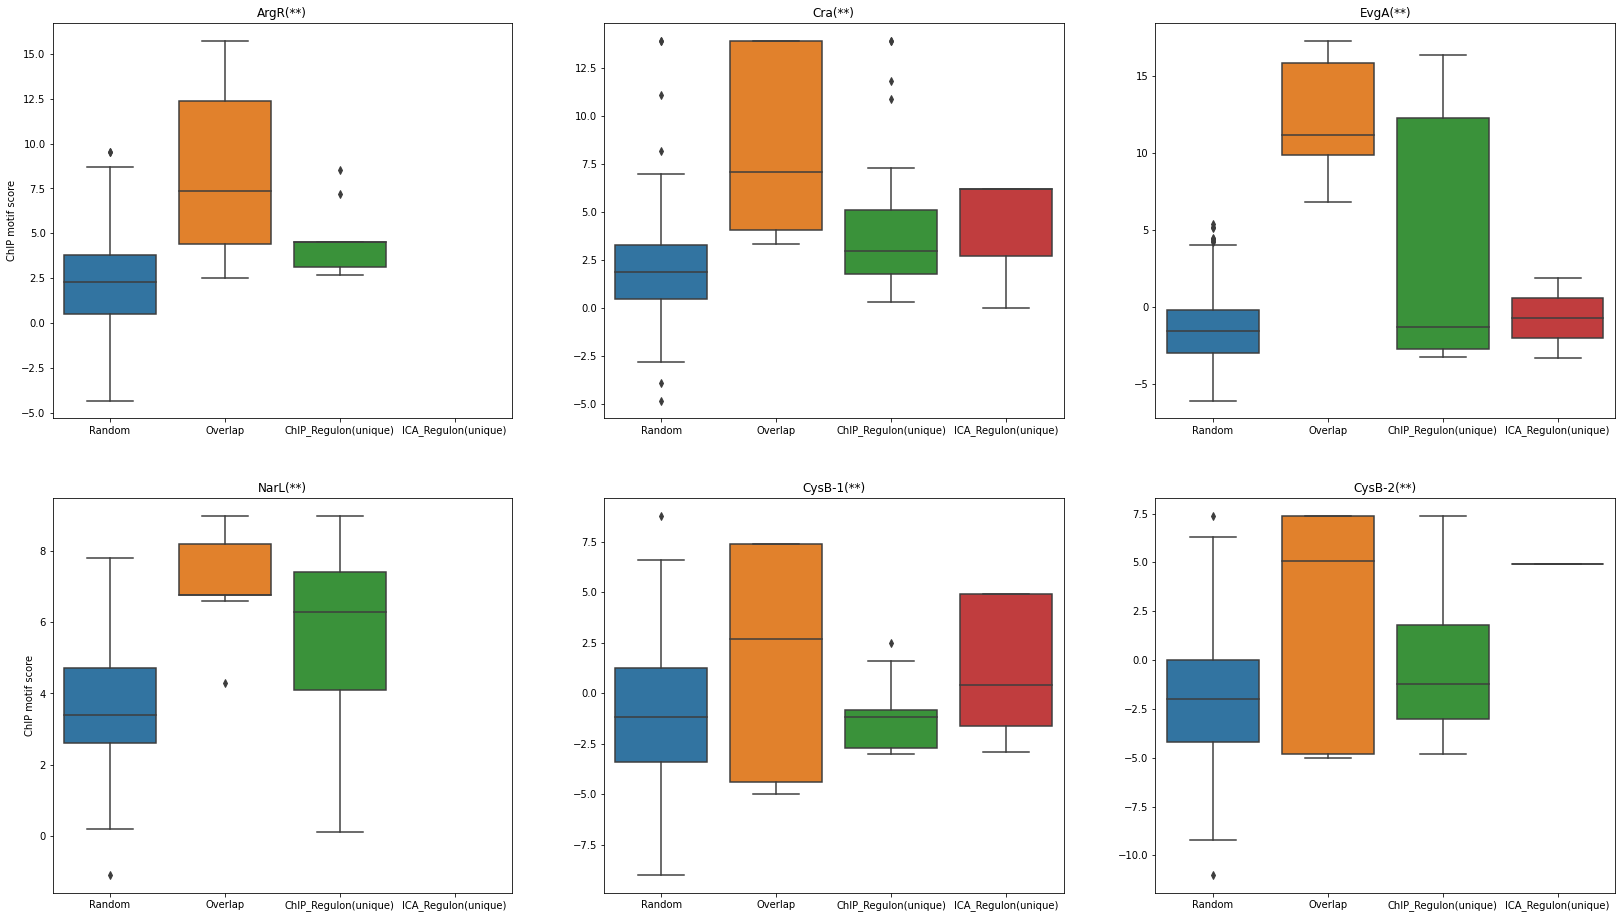

In [144]:
fig, axs = plt.subplots(2,3,figsize=(28,16))
for i in range(6):
    x_axis = i%3
    y_axis = int( i/3 )
    im = IMs_to_check[i]
    sub_data  = data [ IMs_to_check[i] ]
    category = sub_data['category']
    score = sub_data['score']
    sns.boxplot( category, score , ax = axs[y_axis][x_axis], 
                order = ['Random','Overlap','ChIP_Regulon(unique)','ICA_Regulon(unique)'] );
    axs[y_axis][x_axis].set_title(IMs_to_check[i]+"(**)")
    if x_axis == 0:
        axs[y_axis][x_axis].set_ylabel('ChIP motif score')
fig.savefig('../../thesis_plots/TRN_comp_score.svg',dpi=150)

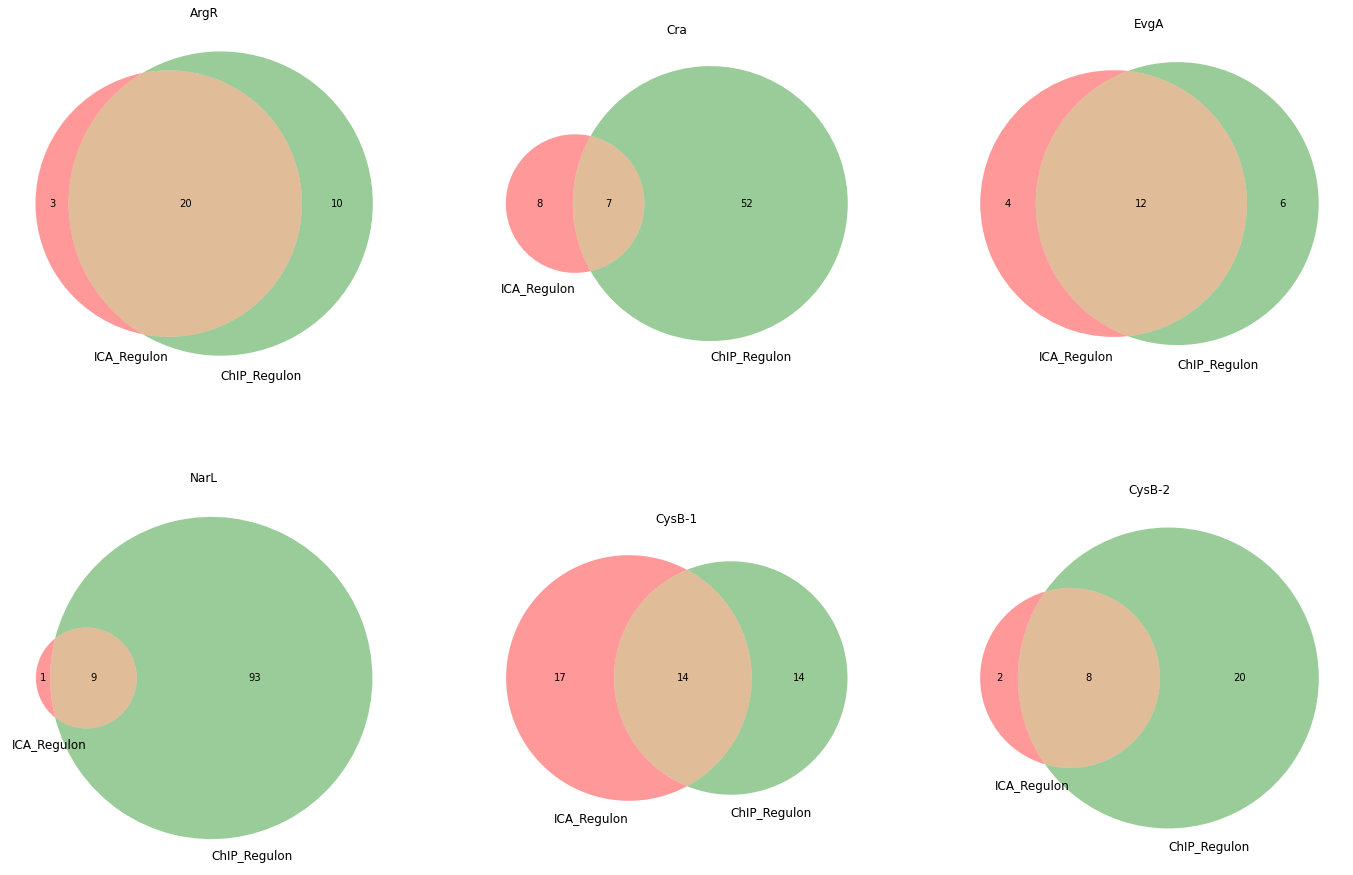

In [33]:
from matplotlib_venn import venn2
fig, axs = plt.subplots(2,3,figsize=(24,16))
for i in range(6):
    x_axis = i%3
    y_axis = int( i/3 )
    im = IMs_to_check[i]
    if im in ['CysB-1','CysB-2','CysB-3']:
        venn2([set(IM_genes[im]),set(regulon_genes['CysB'])],set_labels = ('ICA_Regulon','ChIP_Regulon'), 
              ax = axs[y_axis][x_axis])
    else:    
        venn2([set(IM_genes[im]),set(regulon_genes[im])],set_labels = ('ICA_Regulon','ChIP_Regulon'), 
              ax = axs[y_axis][x_axis])
        
    axs[y_axis][x_axis].set_title(im)
fig.savefig('../../thesis_plots/TRN_venn.svg',dpi=150)

## assess  different data sets performance

In [48]:
TF_scores = pd.DataFrame()
for r in regulon_genes.keys():
    f_name = r
    if f_name == 'FNR':
        f_name = 'Fnr'
    if f_name == 'CRP':
        f_name = 'Crp'
        
    TF_scores[f_name+' score'] = features[f_name+' score']

X_chip = TF_scores.iloc[:,:].values
X_chip = StandardScaler().fit_transform(X_chip)

In [44]:
hyperopt_LR = {}

for y_name, y_labels in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['LR']['model'],
        hyperopt_models['LR']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(  X_chip ,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_LR[y_name] = hyperopt_results_df
    
# combine all the hyperopt results into a DF
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_LR.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)

hyperopt_LR_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)
hyperopt_LR_df.to_csv('data/hyperopt_LR_chipfeature0.csv')

AllR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   29.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
ArcA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   48.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
ArgR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   23.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   54.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
ArgP
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   30.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


max_iter reached after 0 seconds
BaeR+CpxR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   29.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
CpxR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   42.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
CdaR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   31.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


max_iter reached after 0 seconds
Cra
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
Crp-related-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   32.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
EvgA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   23.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
CysB-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   25.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


max_iter reached after 1 seconds
CysB-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   24.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
CysB-3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   42.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds
FadR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
FlhDC-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   38.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


max_iter reached after 0 seconds
FlhDC-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   35.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
Fimbriae
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   28.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished


Text(0.5, 0, 'ICA Regulons')

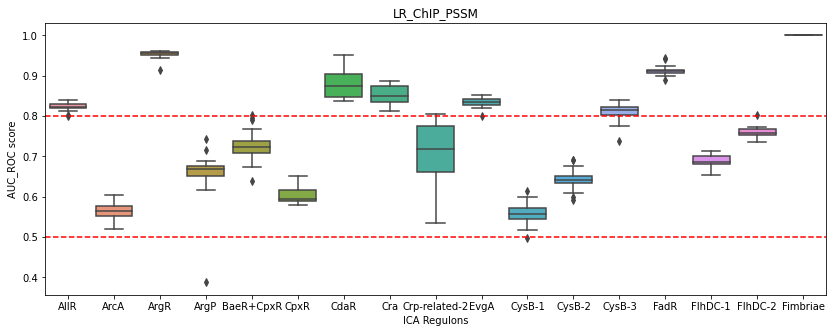

In [17]:
hyperopt_result_df = pd.read_csv( 'data/hyperopt_LR_chipfeature0.csv' , index_col=0)
plt.figure( figsize=(14,5))
#sns.swarmplot(x='im', y='mean_train_score', data=hyperopt_result_df)
sns.boxplot(x='im', y='mean_test_score', data=hyperopt_result_df)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.title('LR_ChIP_PSSM')
plt.ylabel('AUC_ROC score')
plt.xlabel('ICA Regulons')

In [49]:
hyperopt_LR = {}

for y_name, y_labels in y_to_try_3.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['LR']['model'],
        hyperopt_models['LR']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(  X_chip ,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_LR[y_name] = hyperopt_results_df
    
# combine all the hyperopt results into a DF
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_LR.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)

hyperopt_LR_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)
hyperopt_LR_df.to_csv('data/hyperopt_LR_chipfeature3.csv')

PuuR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
RcsAB
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
RhaS
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   55.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 3 seconds
RpoE
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
RpoH
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   39.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
RpoN+FhlA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   32.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 3 seconds
RpoN+NtrC-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
RpoN+NtrC-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   29.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
RpoN+PrpR+Cra
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   34.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
RpoN+PspF
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
RpoS
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   30.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
RpoS+ArgR+RpoN
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   28.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
RutR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   43.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
SoxS
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   27.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 3 seconds
TrpR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   34.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
TyrR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
XylR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   25.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
YdeO+H-NS
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


max_iter reached after 0 seconds


Text(0.5, 0, 'ICA Regulons')

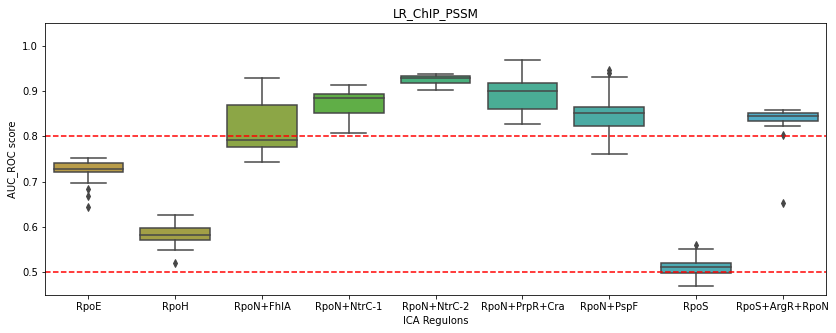

In [18]:
hyperopt_result_df = pd.read_csv( 'data/hyperopt_LR_chipfeature3.csv' , index_col=0)
plt.figure( figsize=(14,5))
#sns.swarmplot(x='im', y='mean_train_score', data=hyperopt_result_df)
sns.boxplot(x='im', y='mean_test_score', data=hyperopt_result_df)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.title('LR_ChIP_PSSM')
plt.xlim([2.5,11.5])
plt.ylim([0.45,1.05])
plt.ylabel('AUC_ROC score')
plt.xlabel('ICA Regulons')

# TF motif score histogram

## DNA feature viewer

In [10]:
from dna_features_viewer import GraphicFeature, GraphicRecord

In [13]:
#'FadR upstreamTSS'    'FadR distToTSS'

In [16]:
raw_data = pd.read_csv('data.csv')

In [33]:
ArcA_2_seqs = [] # store tuples: ( tu.name, gene.id, TF_match_to_tss)
N_UPSTREAM = 150
N_DOWNSTREAM = 30

for bnumber in IM_genes['ArcA-2']:
    gene = bitome.get_gene( b_g[bnumber] )
    strand = int(gene.location.strand)
    if len(gene.transcription_units) < 1:
        continue
        
    for tu in gene.transcription_units:
        if tu.tss == None:
            continue
        
        tss = tu.tss
        if strand == 1:
            seq_loc = FeatureLocation(
                tss - N_UPSTREAM  - 1,
                tss + N_DOWNSTREAM,
                strand
            )
        else:
            seq_loc = FeatureLocation(
                tss - N_UPSTREAM  - 1,
                tss + N_DOWNSTREAM,
                strand
            )
        sequence = seq_loc.extract(bitome.sequence)
        dist = 0
        for i in range( len(raw_data['ID']) ):
            if list(raw_data['ID'])[i] == bnumber and raw_data['TU_length'][i] == len(tu.sequence):
                if  raw_data['ArcA upstreamTSS'][i] == 1:
                    dist =  - (raw_data['ArcA distToTSS'][i])
                else:
                    dist =  (raw_data['ArcA distToTSS'][i])
                    
        ArcA_2_seqs.append( (tu.name, bnumber, dist, sequence ) )

In [41]:
ArcA_2_seqs[0]

('ddpXABCDF',
 'b1486',
 -86.0,
 Seq('ATGGCATGAGATCTGCATAAGCGGAAAGCGCAGCAATTTTTGTCTTATACAGGA...TGT'))

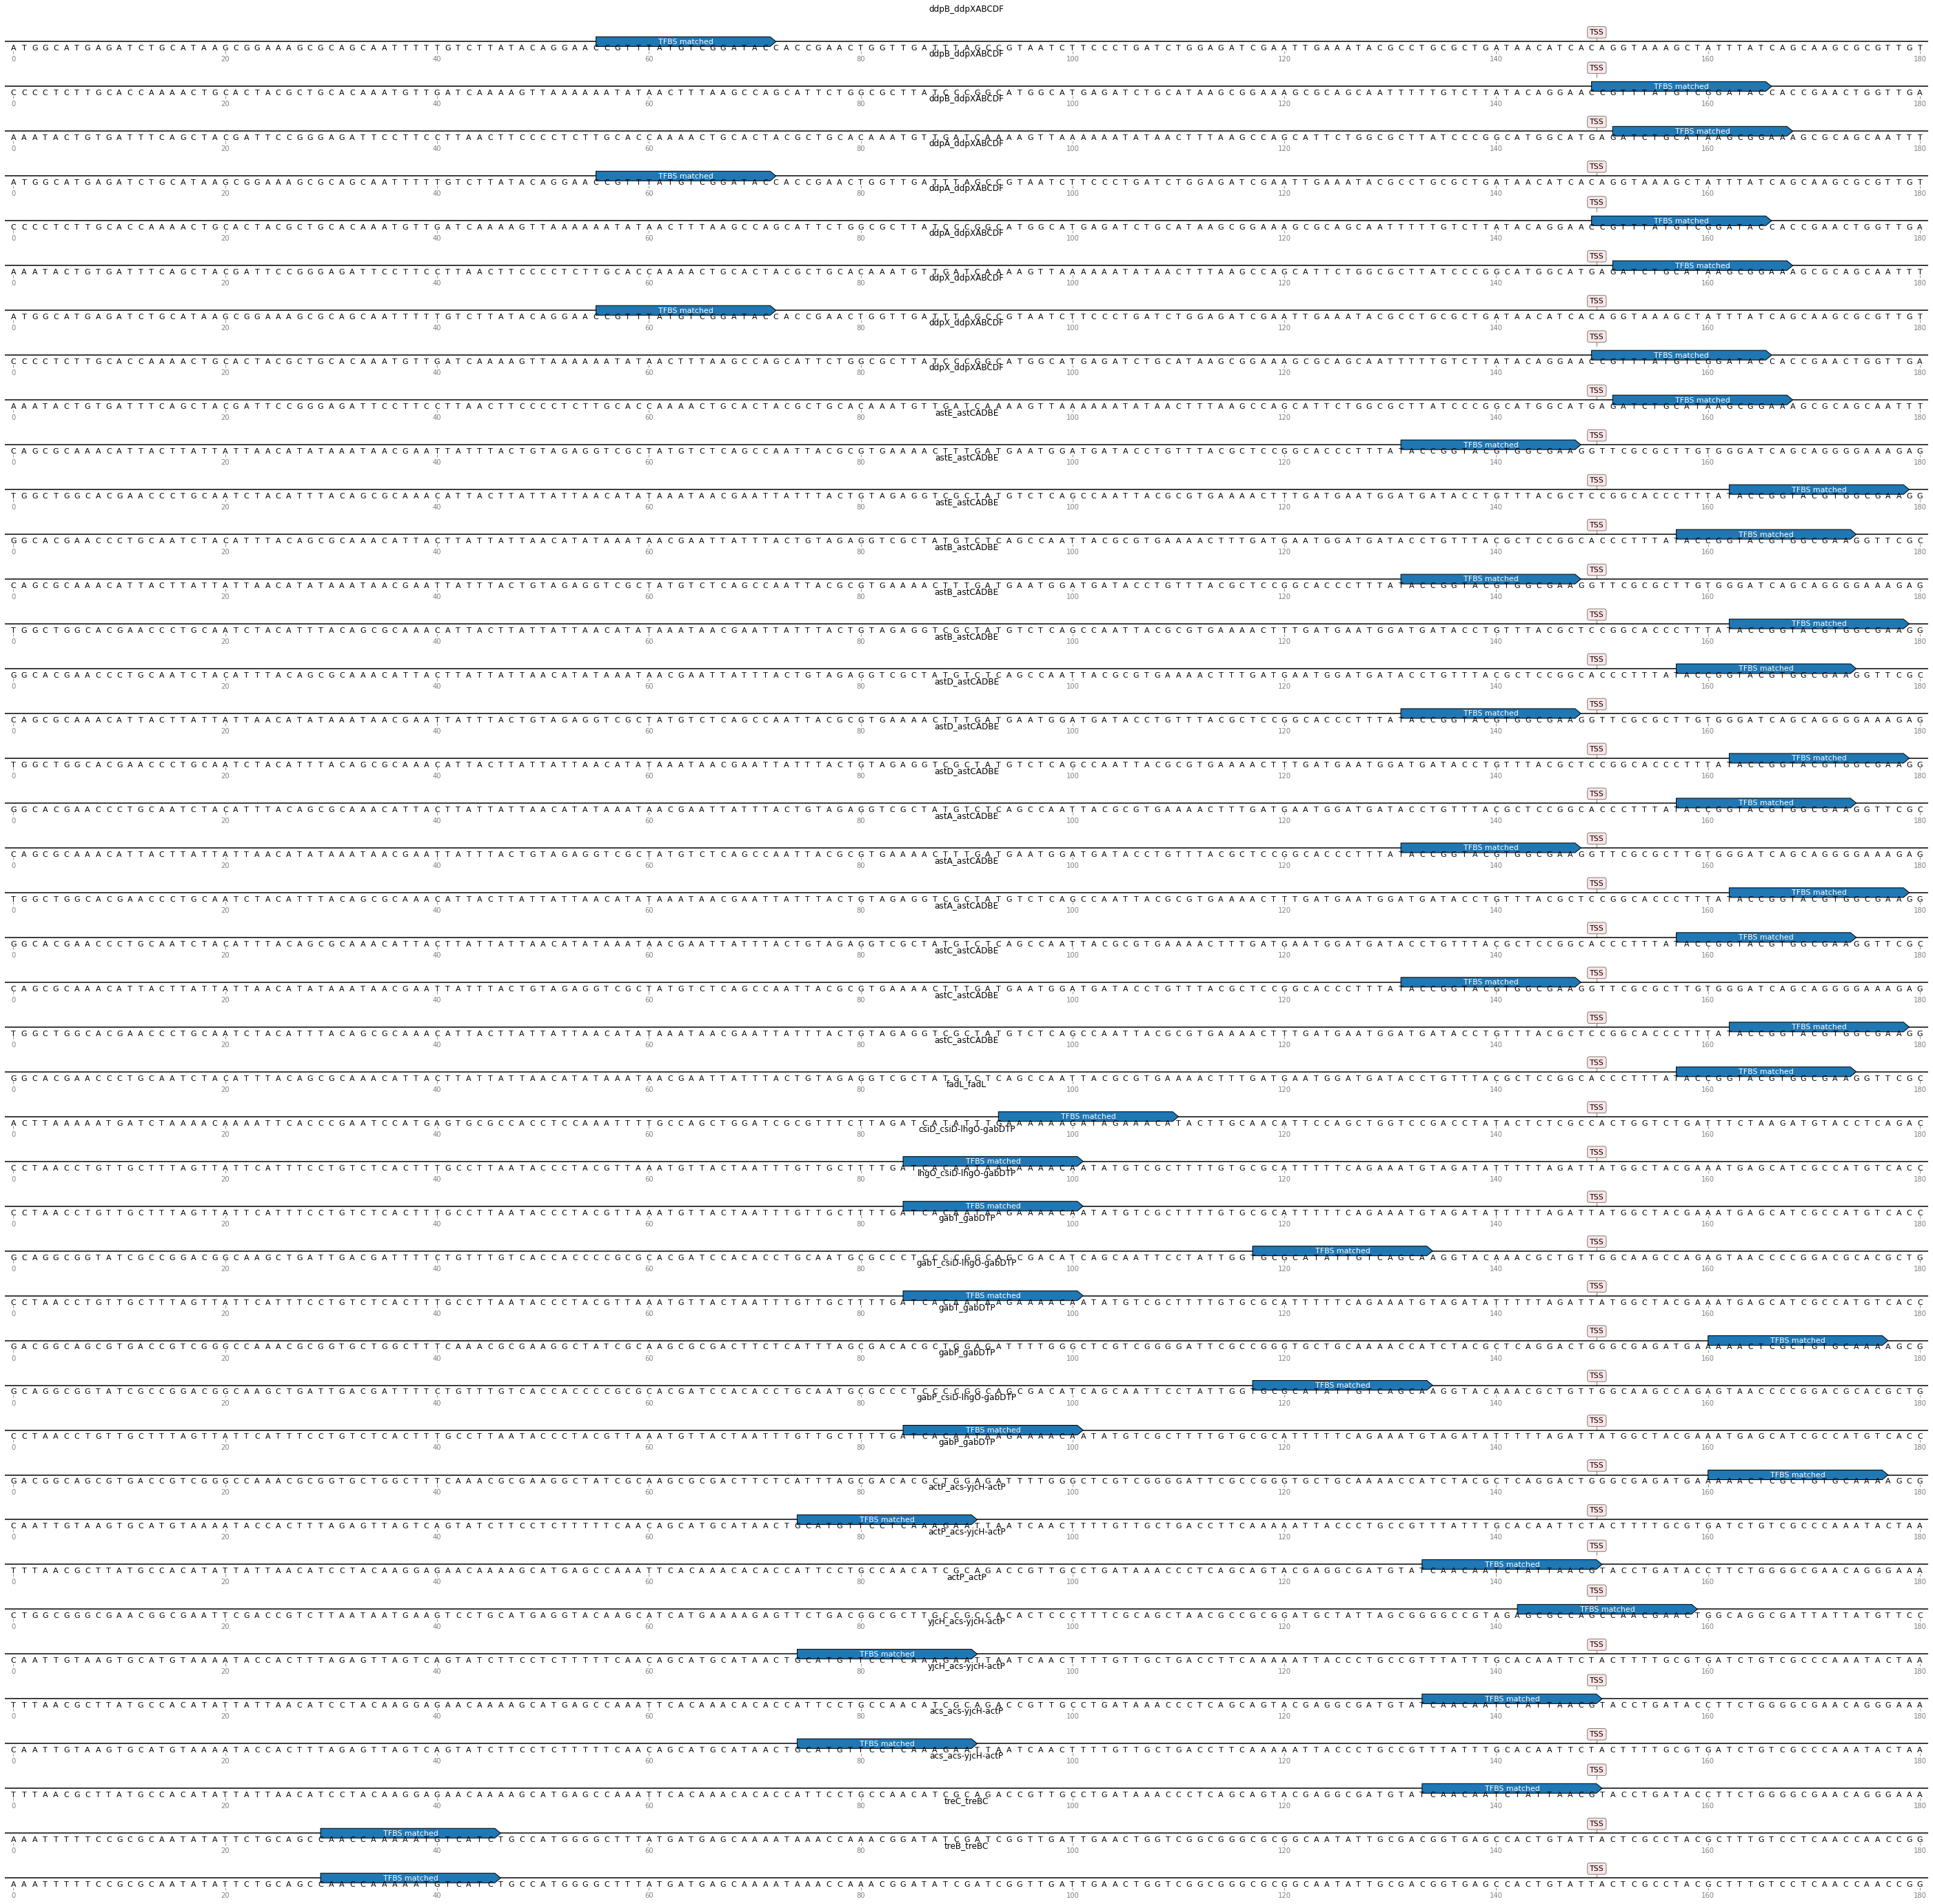

In [46]:
width_ArcA = len(pwm_db['ArcA'])

fig, axs = plt.subplots( len(ArcA_2_seqs), 1, figsize = (50,50) )
for i in range( len(ArcA_2_seqs) ):
    temp_seq = str( ArcA_2_seqs[i][3] )
    gname = b_g[   ArcA_2_seqs[i][1]  ]
    tu_name = ArcA_2_seqs[i][0]
    mid = ArcA_2_seqs[i][2] + 150
    left = mid - width_ArcA/2
    right = mid + width_ArcA/2
    
    record = GraphicRecord(sequence_length= 181 , sequence= temp_seq , features=[
        GraphicFeature(start= 150, end=150, strand=+1, color='red',label="TSS"),
        GraphicFeature(start= left, end=right, strand=+1, color='tab:blue',label = "TFBS matched")
    ])
    record.plot(figure_width=5, ax = axs[i])
    record.plot_sequence(ax = axs[i])
    axs[i].set_title( gname + '_' + tu_name, pad = 0.1 )
    

In [67]:
TF_tss = {}
for tf in bitome.transcription_factors:
    if tf.name in tf_list:
        TF_tss[tf.name] = []   
        for r in tf.regulons:
                for p in list(r.regulated_promoters.values())[0]:
                    if p.transcription_unit != None and p.tss!=None:
                        tss = p.tss
                        for tfbs in p.tf_binding_sites:
                            start = int(tfbs.location.start)
                            end = int(tfbs.location.start)
                            TF_tss[tf.name].append( (p.name, start,end,tss,int(p.location.strand)) )

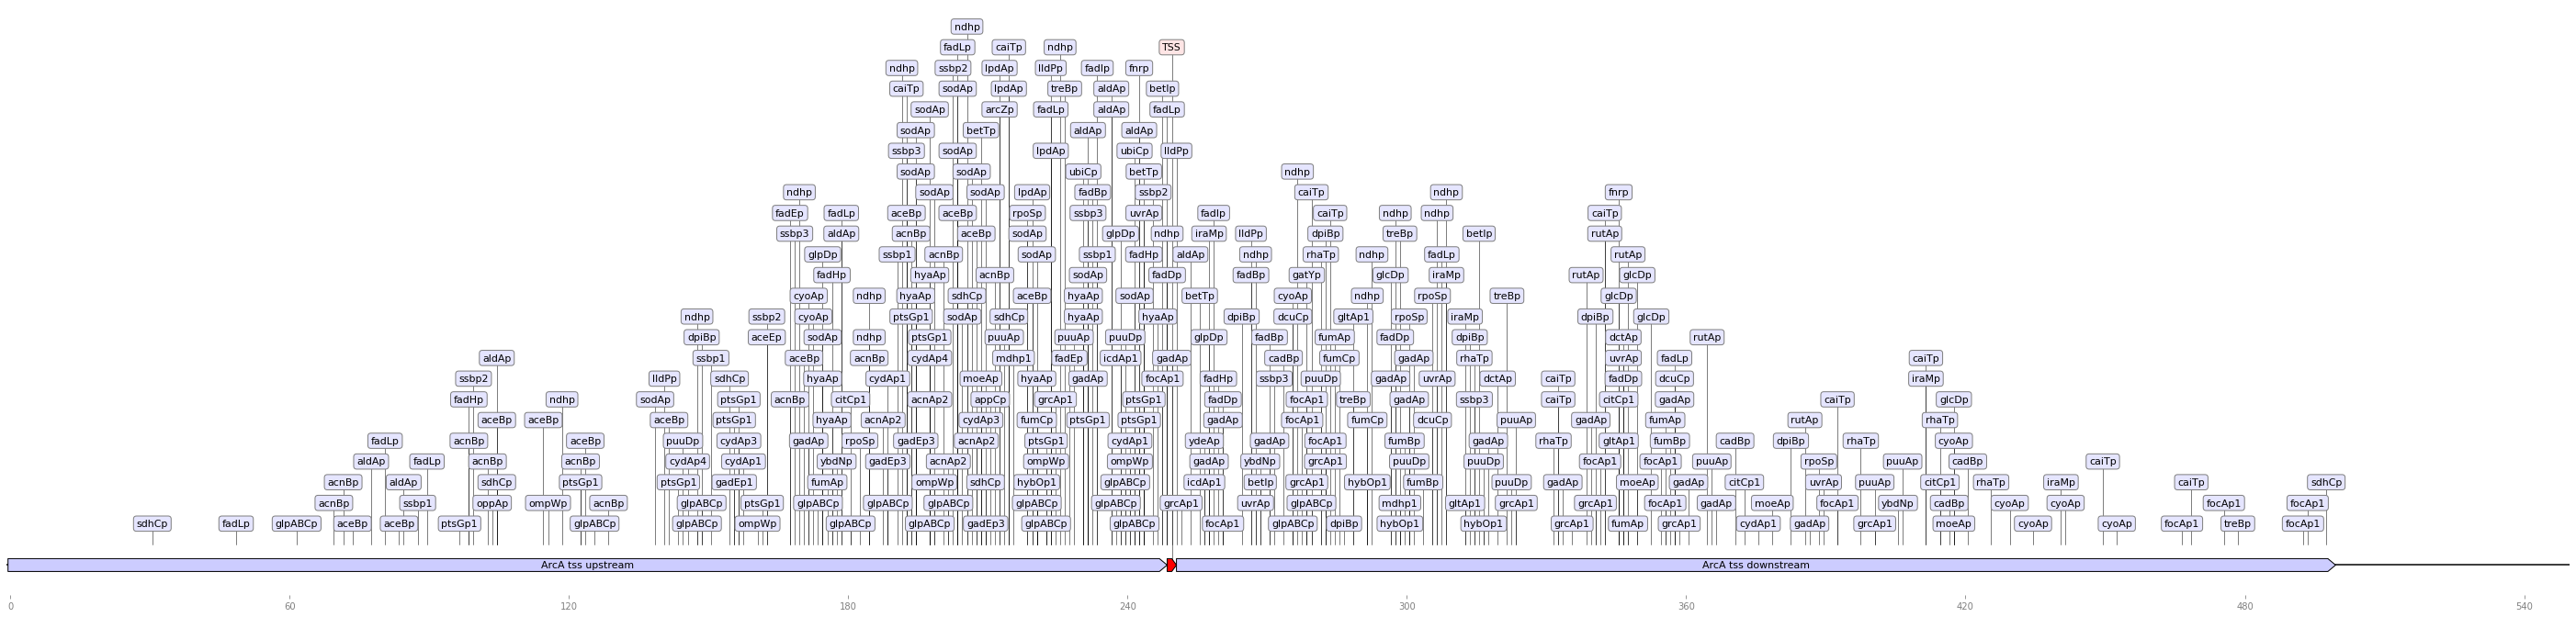

In [74]:
features=[
    GraphicFeature(start=0, end=249, strand=+1, color="#ccccff",
                   label="ArcA tss upstream"),
    GraphicFeature(start=251, end=500, strand=+1, color="#ccccff",
                   label="ArcA tss downstream"),
    GraphicFeature(start=249, end=251, strand=+1, color="red",
                   label="TSS")
]
for promoter_name, start, end, tss, strand in TF_tss['ArcA']:
    temp_start = 250 - (tss-start)
    temp_end = 250 - (tss-end )
    if temp_start > 0 and temp_end < 500:
        
        temp = GraphicFeature(start= 250 - (tss-start), end= 250 - (tss-end ) , strand=+1, color="blue",
                   label= promoter_name );
        features.append(temp);

record = GraphicRecord(sequence_length=550, features=features);
record.plot(figure_width=50);

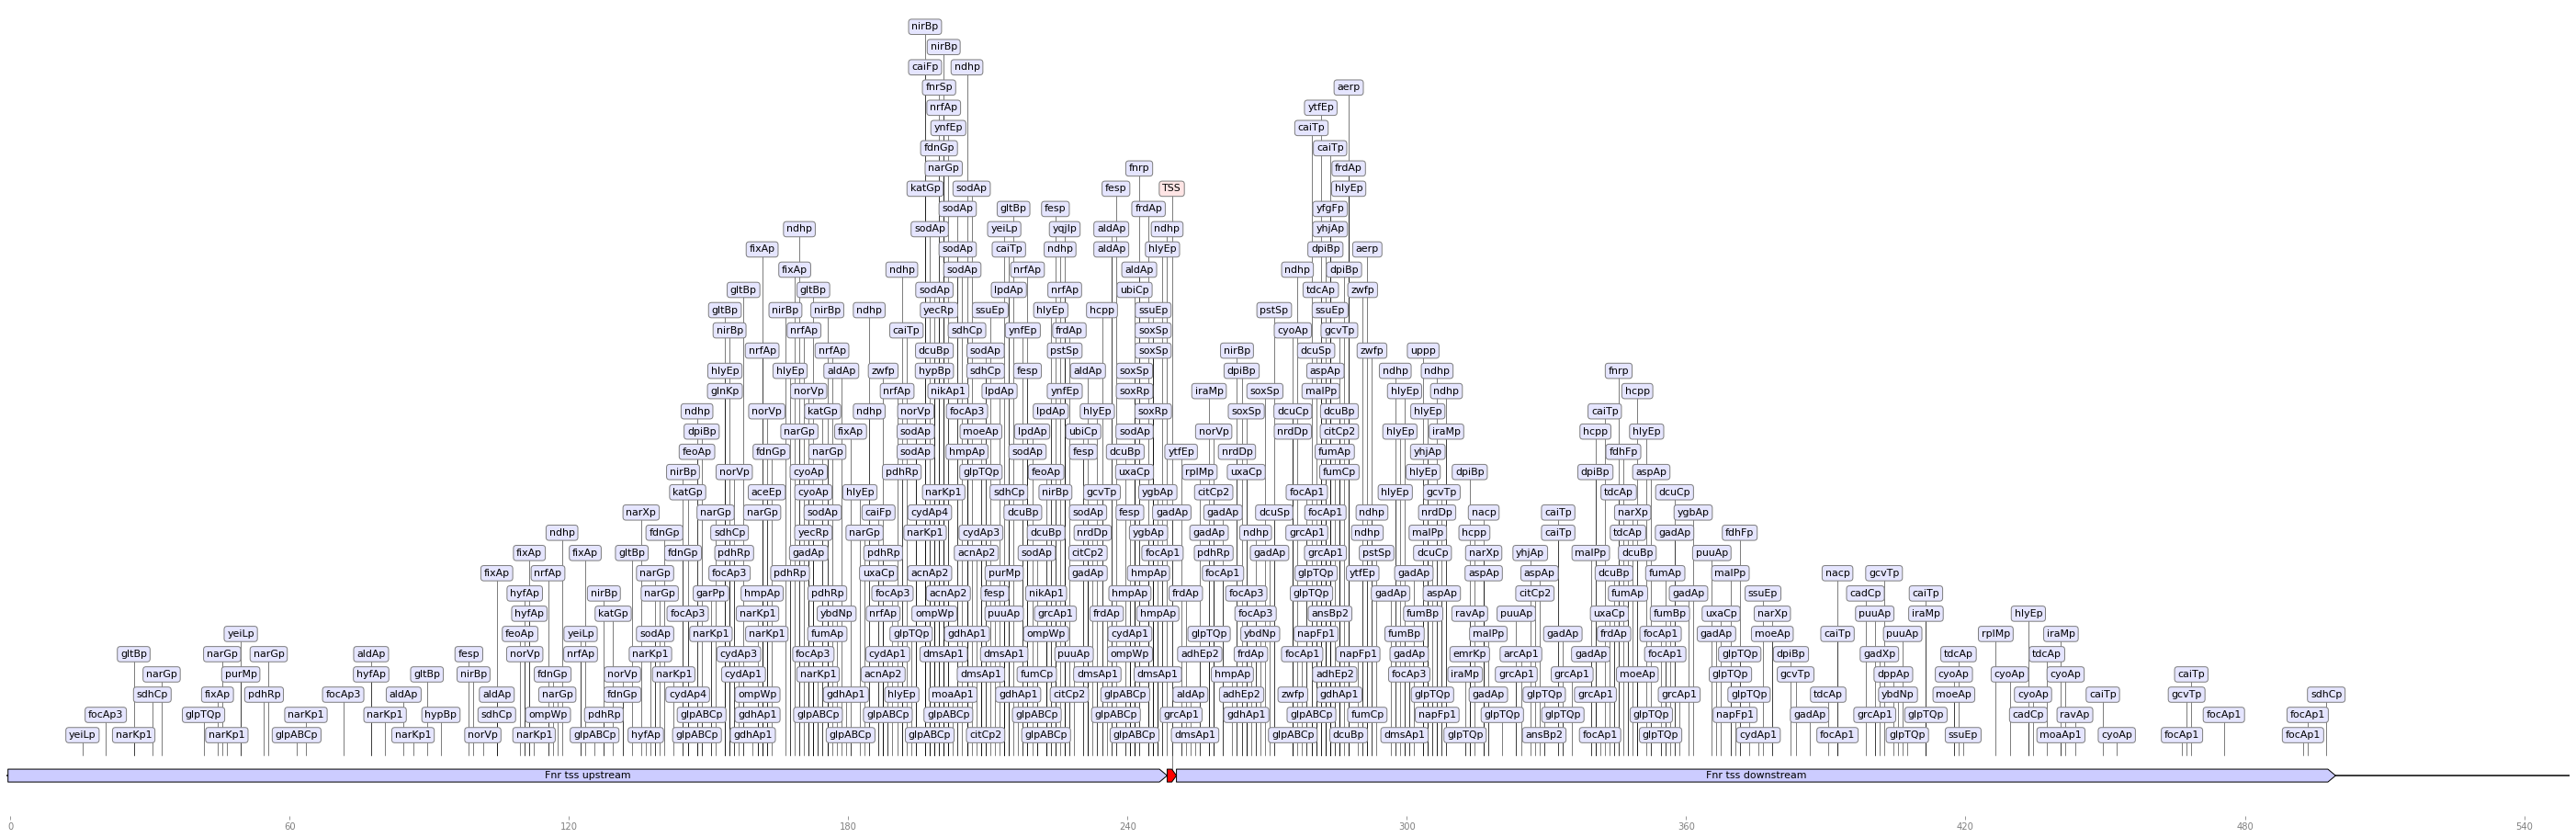

In [75]:
features=[
    GraphicFeature(start=0, end=249, strand=+1, color="#ccccff",
                   label="Fnr tss upstream"),
    GraphicFeature(start=251, end=500, strand=+1, color="#ccccff",
                   label="Fnr tss downstream"),
    GraphicFeature(start=249, end=251, strand=+1, color="red",
                   label="TSS")
]
for promoter_name, start, end, tss, strand in TF_tss['FNR']:
    temp_start = 250 - (tss-start)
    temp_end = 250 - (tss-end )
    if temp_start > 0 and temp_end < 500:
        
        temp = GraphicFeature(start= 250 - (tss-start), end= 250 - (tss-end ) , strand=+1, color="blue",
                   label= promoter_name );
        features.append(temp);

record = GraphicRecord(sequence_length=550, features=features);
record.plot(figure_width=50);

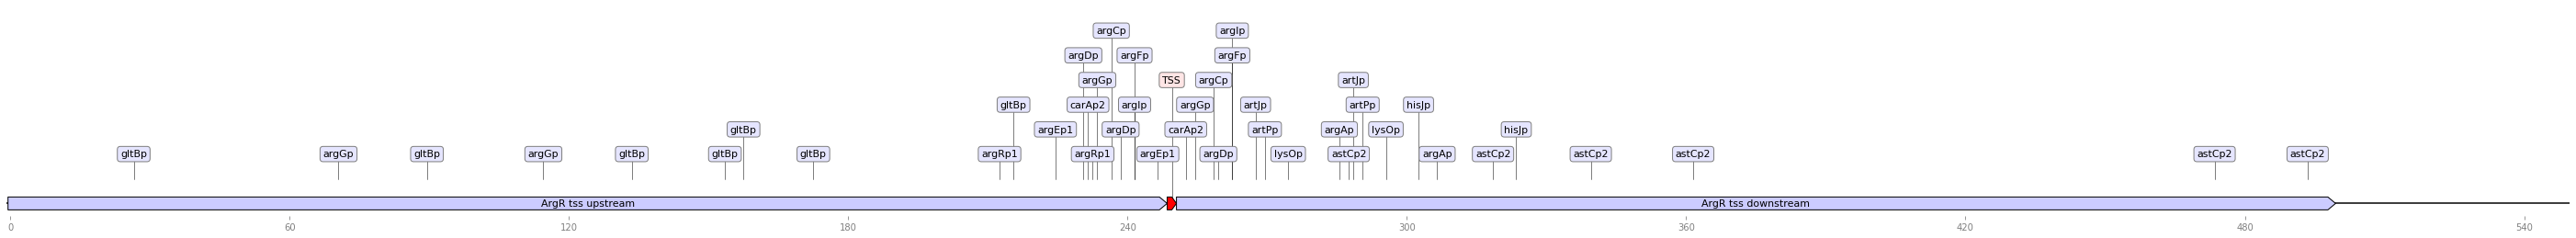

In [76]:
features=[
    GraphicFeature(start=0, end=249, strand=+1, color="#ccccff",
                   label="ArgR tss upstream"),
    GraphicFeature(start=251, end=500, strand=+1, color="#ccccff",
                   label="ArgR tss downstream"),
    GraphicFeature(start=249, end=251, strand=+1, color="red",
                   label="TSS")
]
for promoter_name, start, end, tss, strand in TF_tss['ArgR']:
    temp_start = 250 - (tss-start)
    temp_end = 250 - (tss-end )
    if temp_start > 0 and temp_end < 500:
        
        temp = GraphicFeature(start= 250 - (tss-start), end= 250 - (tss-end ) , strand=+1, color="blue",
                   label= promoter_name );
        features.append(temp);

record = GraphicRecord(sequence_length=550, features=features);
record.plot(figure_width=50);

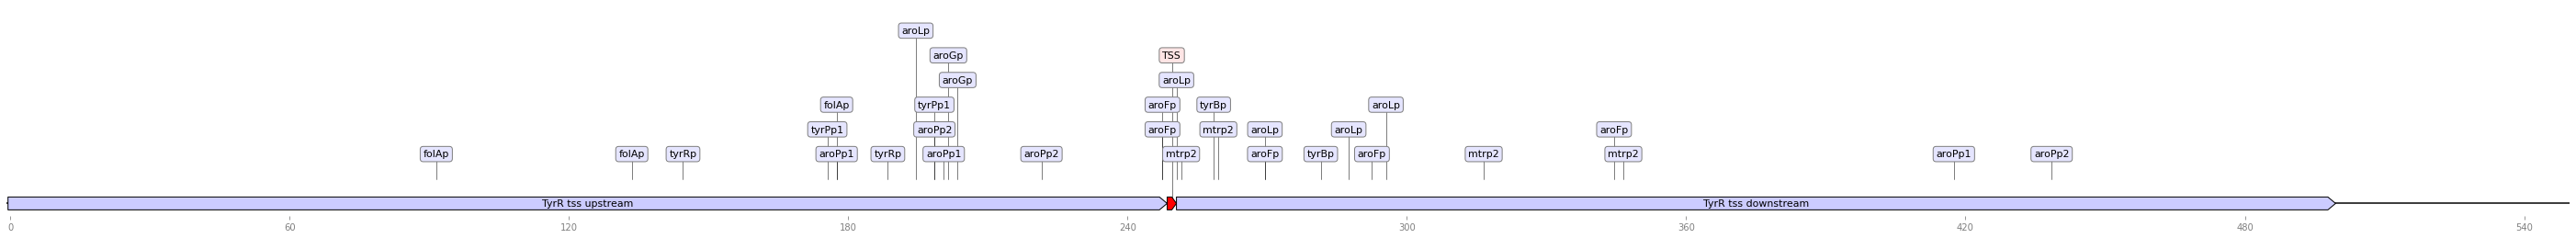

In [79]:
features=[
    GraphicFeature(start=0, end=249, strand=+1, color="#ccccff",
                   label="TyrR tss upstream"),
    GraphicFeature(start=251, end=500, strand=+1, color="#ccccff",
                   label="TyrR tss downstream"),
    GraphicFeature(start=249, end=251, strand=+1, color="red",
                   label="TSS")
]
for promoter_name, start, end, tss, strand in TF_tss['TyrR']:
    temp_start = 250 - (tss-start)
    temp_end = 250 - (tss-end )
    if temp_start > 0 and temp_end < 500:
        
        temp = GraphicFeature(start= 250 - (tss-start), end= 250 - (tss-end ) , strand=+1, color="blue",
                   label= promoter_name );
        features.append(temp);

record = GraphicRecord(sequence_length=550, features=features);
record.plot(figure_width=50);

In [100]:
dist_tss = []
for promoter_name, start, end, tss, strand in TF_tss['TyrR']:
    if (start+end)/2 - tss > -200 and (start+end)/2 - tss < 200:
        dist_tss.append( (start+end)/2 - tss )

Text(0.5, 1.0, 'TyrR TFBS distance to TSS')

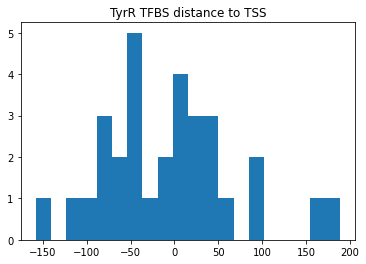

In [101]:
plt.hist(dist_tss,bins=20);
plt.title('TyrR TFBS distance to TSS')

In [16]:
reg_score = {}
for name in pwm_db.keys():
    reg_score[name] = []
    
for name in pwm_db.keys():
    if name == 'Crp':
        tfname = 'CRP'
    elif name == 'Fnr':
        tfname = 'FNR'
    else:
        tfname = name 
    for i in range( len(features['ID']) ):
        if b_g[ features['ID'][i] ] in regulon_genes[tfname]:
            reg_score[name].append( features[name+' score'][i] ) 

Text(0.5, 0.91, 'TFBS Motif Match Scores')

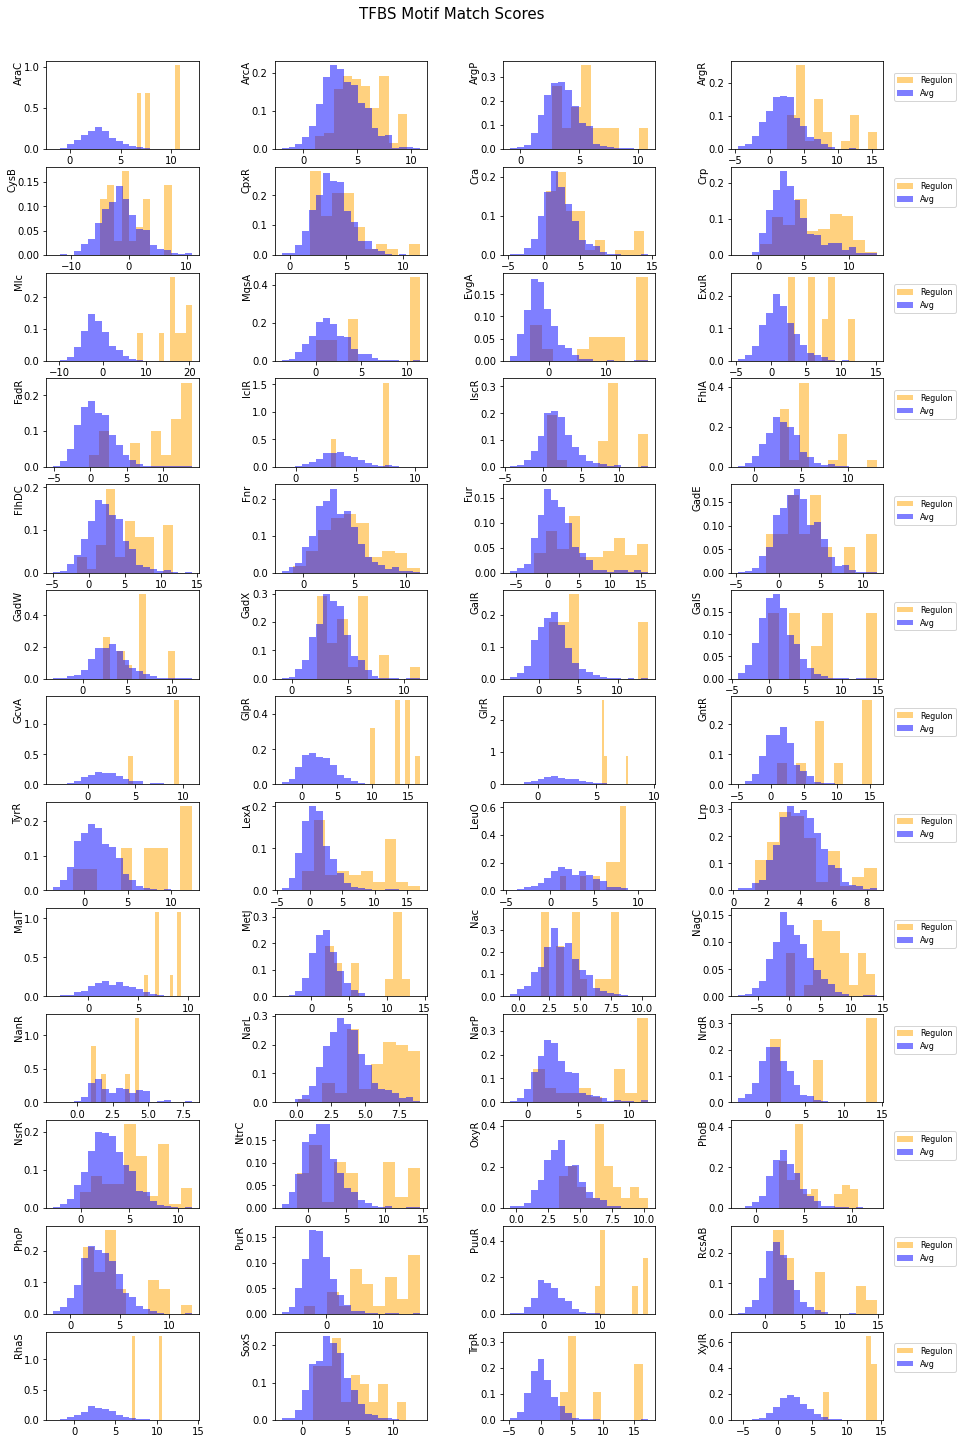

In [76]:
fig,axs = plt.subplots(13,4, figsize = (15,25))
for i in range(0,52):
    y = int( i%4 )
    x = int((i - y)/4  )
    name = list( pwm_db.keys() )[i]
    axs[x,y].hist( reg_score[name], bins=10,density=True, alpha=0.5,color ='orange',label="Regulon")
    axs[x,y].hist(  list(features[name+' score']) , bins = 20, density=True, color='b',alpha = 0.5, label='Avg' )
    axs[x,y].set_ylabel(name, labelpad =0, loc ='top')
    if y == 3:
        axs[x,y].legend(loc='lower right', fontsize=8, bbox_to_anchor=(1.5, 0.5))
plt.subplots_adjust(wspace = 0.5 )
fig.suptitle('TFBS Motif Match Scores',fontsize=15, y=0.91 ) 

# IM motif score histogram

In [7]:
pwm_im = rlogodds('data/motif_logodds.txt')

In [19]:
im_score = {}
for name in pwm_im.keys():
    im_score[name] = []
    
for name in pwm_im.keys():
    
    for i in range( len(features['ID']) ):
        if features['ID'][i] in IM_genes[name]:
            im_score[name].append( features[name+' im score'][i] ) 

Text(0.5, 0.91, 'IM Motif Match Scores')

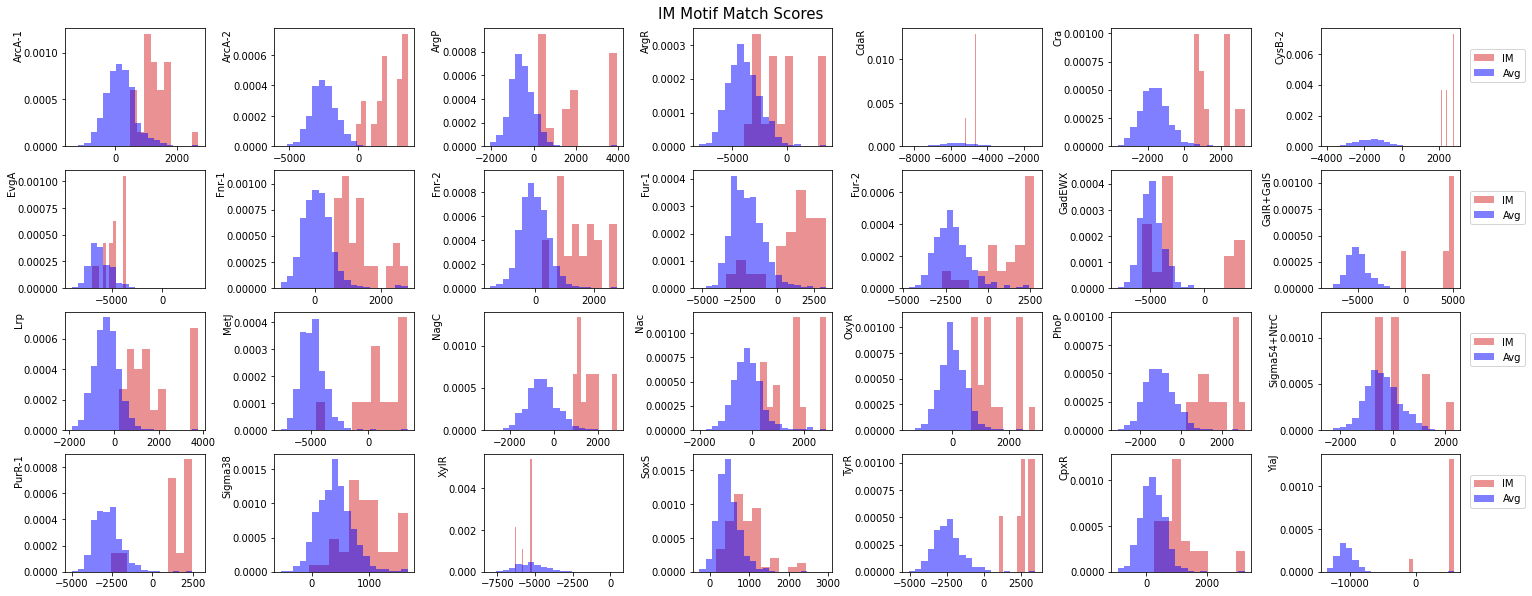

In [25]:
fig,axs = plt.subplots(4,7, figsize = (25,10))
for i in range(0,28):
    y = int( i%7 )
    x = int((i - y)/7  )
    name = list( pwm_im.keys() )[i]
    axs[x,y].hist( im_score[name], bins=10,density=True, alpha=0.5,color ='tab:red',label="IM")
    axs[x,y].hist(  list(features[name+' im score']) , bins = 20, density=True, color='b',alpha = 0.5, label='Avg' )
    axs[x,y].set_ylabel(name, labelpad =0, loc ='top')
    if y == 6:
        axs[x,y].legend(loc='lower right', fontsize=10, bbox_to_anchor=(1.5, 0.5))
plt.subplots_adjust(wspace = 0.5 )
fig.suptitle('IM Motif Match Scores',fontsize=15, y=0.91 ) 

# sigma factor scoring

In [8]:
#sig_list = ['Sigma70','Sigma32','Sigma38','Sigma24','Sigma28','Sigma54']
sig_im = [ 'Sigma28','Sigma54+NtrC','Sigma38', 'Sigma32']
prib_score = {}
m35_score = {}
for name in sig_im:
    prib_score[name] = []
    m35_score[name] = []
    
for name in sig_im:
    if name == 'Sigma54+NtrC':
        signame = 'Sigma54'
    else:
        signame = name
        
    for i in range( len(features['ID']) ):
        if features['ID'][i] in IM_genes[name]:
            prib_score[name].append( features[signame + '_Prib_score'][i] )
            m35_score[name].append( features[signame + '_m35_score'][i] )

Text(0.48, 0.48, 'M35 Box Scores')

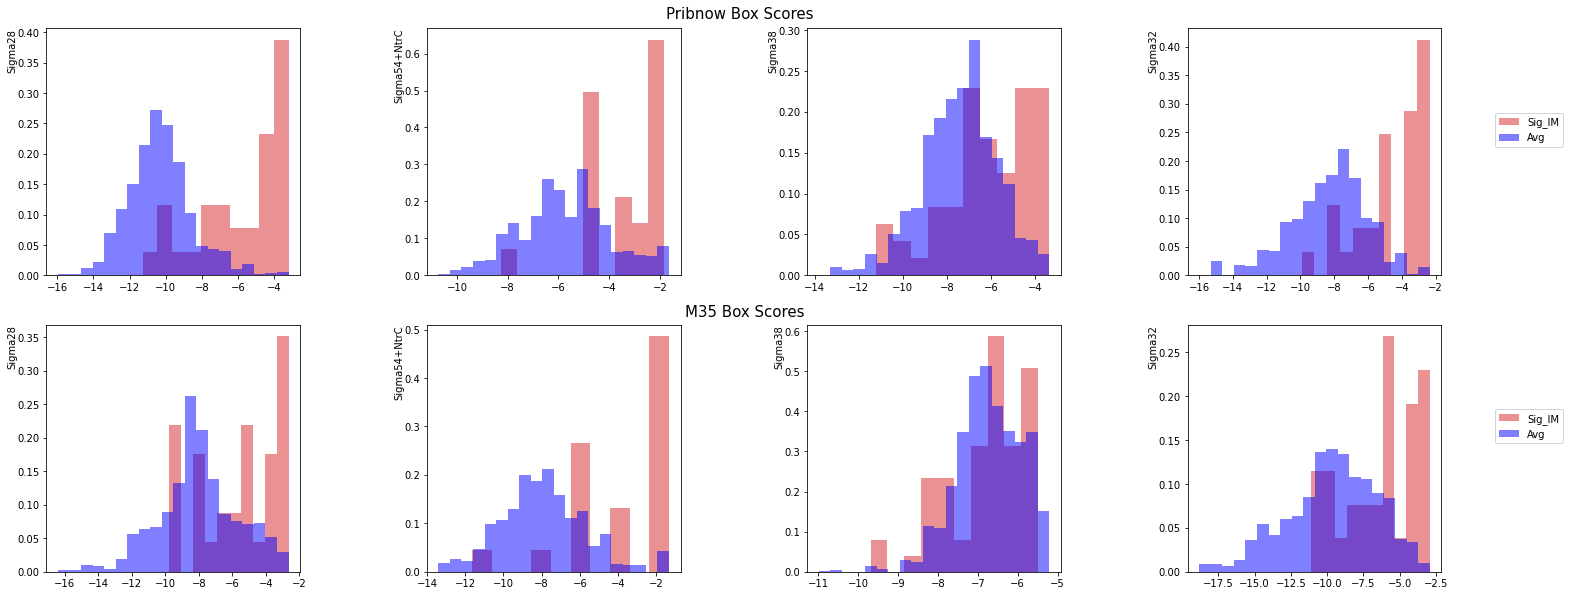

In [22]:
fig,axs = plt.subplots(2,4, figsize = (25,10))
for i in range(0,8):
    y = int( i%4 )
    x = int((i - y)/4  )
    name = sig_im[y]
    
    if name == 'Sigma54+NtrC':
        signame = 'Sigma54'
    else:
        signame = name
        
    if x == 0:
        axs[x,y].hist( prib_score[name], bins=10,density=True, alpha=0.5,color ='tab:red',label="Sig_IM")
        axs[x,y].hist(  list(features[signame + '_Prib_score']) , bins = 20, 
                      density=True, color='b',alpha = 0.5, label='Avg' )
    else:
        axs[x,y].hist( m35_score[name], bins=10,density=True, alpha=0.5,color ='tab:red',label="Sig_IM")
        axs[x,y].hist(  list(features[signame + '_m35_score']) , bins = 20, 
                      density=True, color='b',alpha = 0.5, label='Avg' )
        
    axs[x,y].set_ylabel(name, labelpad =0, loc ='top')
    if y == 3:
        axs[x,y].legend(loc='lower right', fontsize=10, bbox_to_anchor=(1.5, 0.5))
    
plt.subplots_adjust(wspace = 0.5 )
fig.suptitle('Pribnow Box Scores',fontsize=15,x=0.51, y=0.91 ) 
fig.text(x=0.48, y = 0.48,s= 'M35 Box Scores',fontsize=15 )

In [23]:
#sig_list = ['Sigma70','Sigma32','Sigma38','Sigma24','Sigma28','Sigma54']
sig_im = [ 'Sigma28','Sigma54+NtrC','Sigma38', 'Sigma32']
prib_hmd = {}
m35_hmd = {}
for name in sig_im:
    prib_hmd[name] = []
    m35_hmd[name] = []
    
for name in sig_im:
    if name == 'Sigma54+NtrC':
        signame = 'Sigma54'
    else:
        signame = name
        
    for i in range( len(features['ID']) ):
        if features['ID'][i] in IM_genes[name]:
            prib_hmd[name].append( features[signame + '_Prib_hmd'][i] )
            m35_hmd[name].append( features[signame + '_m35_hmd'][i] )

Text(0.48, 0.48, 'M35 Box hmd')

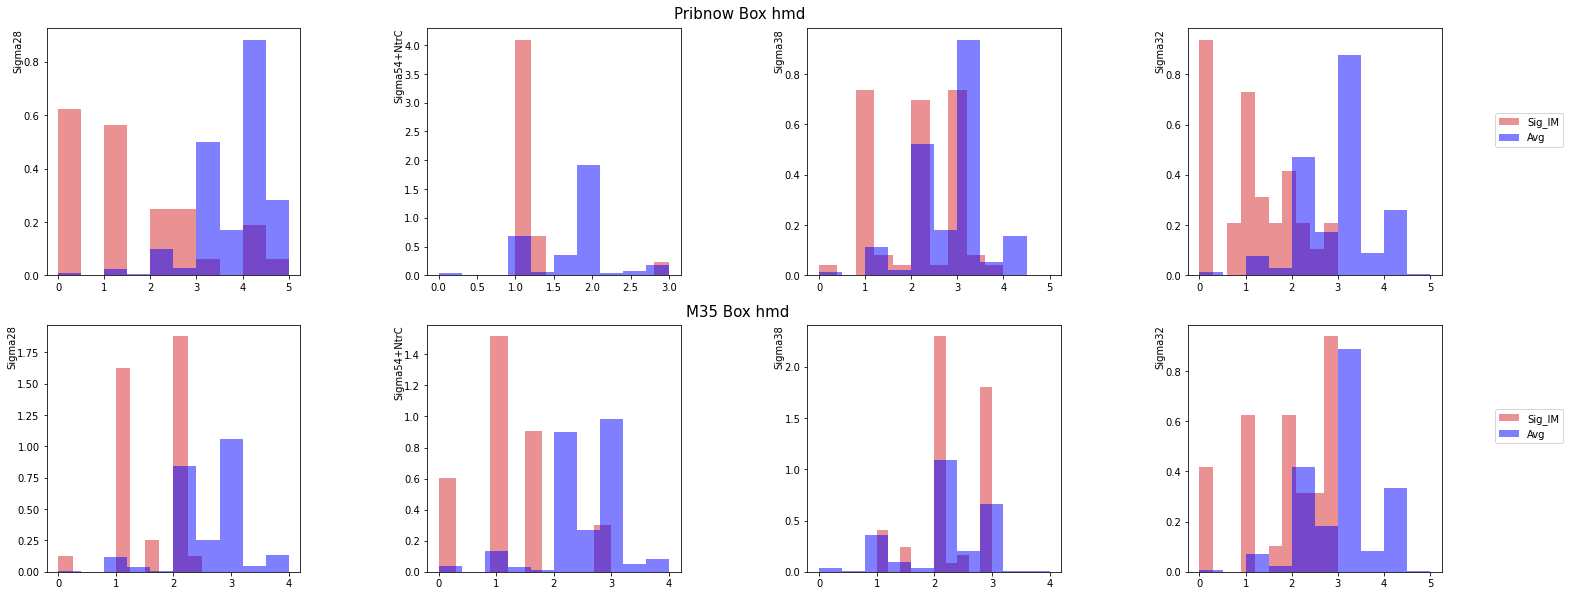

In [25]:
fig,axs = plt.subplots(2,4, figsize = (25,10))
for i in range(0,8):
    y = int( i%4 )
    x = int((i - y)/4  )
    name = sig_im[y]
    
    if name == 'Sigma54+NtrC':
        signame = 'Sigma54'
    else:
        signame = name
        
    if x == 0:
        axs[x,y].hist( prib_hmd[name], bins=10,density=True, alpha=0.5,color ='tab:red',label="Sig_IM")
        axs[x,y].hist(  list(features[signame + '_Prib_hmd']) , bins = 10, 
                      density=True, color='b',alpha = 0.5, label='Avg' )
    else:
        axs[x,y].hist( m35_hmd[name], bins=10,density=True, alpha=0.5,color ='tab:red',label="Sig_IM")
        axs[x,y].hist(  list(features[signame + '_m35_hmd']) , bins = 10, 
                      density=True, color='b',alpha = 0.5, label='Avg' )
        
    axs[x,y].set_ylabel(name, labelpad =0, loc ='top')
    if y == 3:
        axs[x,y].legend(loc='lower right', fontsize=10, bbox_to_anchor=(1.5, 0.5))
    
plt.subplots_adjust(wspace = 0.5 )
fig.suptitle('Pribnow Box hmd',fontsize=15,x=0.51, y=0.91 ) 
fig.text(x=0.48, y = 0.48,s= 'M35 Box hmd',fontsize=15 )